In [37]:
%matplotlib notebook

In [38]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import celerite
from celerite import terms
import emcee
import corner
from scipy import signal
from IPython.display import display, Math, Image
import os
from astropy.io import fits
import pandas as pd

In [39]:
dir = os.getcwd()
dir

'C:\\Users\\Marc\\Documents\\repo\\stage_m2\\src'

In [40]:
par_dir = os.path.dirname(dir)
par_dir

'C:\\Users\\Marc\\Documents\\repo\\stage_m2'

In [73]:
def log_likelihood(params,time,flux):
        gp.set_parameter_vector(params)
        ll = gp.log_likelihood(flux)
        return ll if np.isfinite(ll) else -np.inf

### Définition de la likelihood ###
def log_likelihood(params,time,flux):
    gp.set_parameter_vector(params)
    ll = gp.log_likelihood(flux)
    return ll if np.isfinite(ll) else -np.inf

### Définition du prior (uniforme) ###
def log_prior(params):
    if ((-30 < params[0] < 20) and (-10 < params[1] < 10) and (5 < params[2] < 7) and (-1000 < params[3] < 1000)) :
        return 0
    return -np.inf

### Définition du posterior ###
def log_probability(params,time,flux):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,time,flux) if np.isfinite(lp) else -np.inf

    ### MCMC ###
def run_mcmc(time,flux,gp) :
    initial = gp.get_parameter_vector()
    ndim, nwalkers = len(initial), 128
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,args=(time,flux))

    print("Running burn-in...")
    p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
    p0, lp, _ = sampler.run_mcmc(p0, 500,progress=True)

    print("Running production...")
    sampler.reset()
    sampler.run_mcmc(p0, 5000,progress=True)
    print("Finished")
    
    likelihood = gp.log_likelihood(flux)
    af = sampler.acceptance_fraction
    
    print("Mean acceptance fraction:", np.mean(af))
    print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
    print("Final MCMC log likelihood: {0}".format(gp.log_likelihood(flux)))
    return(sampler,likelihood)

In [42]:
def gp_building(param,time,flux,error) :
    bounds = dict(log_S0= (None,None), log_Q = (-10,10), log_omega0 = (5,7))
    #kernel = terms.SHOTerm(log_S0=7., log_Q=2.5, log_omega0=5.)
    kernel = terms.SHOTerm(log_S0=param[0], log_Q=param[1], log_omega0=param[2],bounds=bounds)


    gp = celerite.GP(kernel,fit_mean=True)
    gp.compute(time,yerr=error)
 
    print("Initial log likelihood: {0}".format(gp.log_likelihood(flux)))
    print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
    
    return gp

In [67]:
### DATA ###
photo_res = pd.read_csv(par_dir + "/data/Posteriors_photometries_new.csv").ffill().set_index(['Photometry','Sector'])

sectors_names = {
#     "TESS_18_19" : ["All","Sector1","Sector2","Sector3"],
#                  "TESS_18_0" : ["All"],
#                  "TESS_18_1" : ["All"],
#                  "TESS_18_2" : ["All"],
                 "TESS_19" : ["All"],
#                  "TESS_20_0" : ["All"]
#                  "TESS_20_1" : ["All","Sector1","Sector2"],
#                  "TESS_21" : ["All","Sector1","Sector2"]
}

rv_time_plot_obs = np.array([544.4,780.71,799.71,829.66,851.32,913.54,1131.79,1170.70,1519.79,1566.70,1597.62,2569.81,2583.88,2685.70,2694.56,2707.08,2985.24,3344.74,3668.00,3712.63,3770.45,3849.51,4007.84,4037.19,4064.77,4094.64,4207.68,4233.60,4525.58,4787.42,4828.73,4907.33,4922.58])

In [68]:
photo_res

Likelihood     Log S0     Log Q    Log w0  Inc - S0  \
Photometry Sector                                                            
TESS_18_0  All     -142358.904981  12.586912  0.114582  5.571613  0.036583   
TESS_18_1  All     -145339.898760   8.883048  3.111981  5.754014  0.021142   
TESS_18_19 All      315081.836837 -21.057320  2.150781  5.764506  0.014603   
           Sector1  116041.275491 -21.748926  2.878606  5.757228  0.023285   
           Sector2   88085.140921 -20.880149  1.962393  5.766474  0.027147   
           Sector3  111674.889117 -20.618459  1.686964  5.773898  0.024183   
TESS_18_2  All     -126536.323325  10.034609  1.984541  5.746049  0.025430   
TESS_19    All     -139890.792582   9.871351  2.073424  5.766396  0.026127   
TESS_20_0  All     -143882.355319   8.857675  2.986948  5.743849  0.022156   
           Sector1  -68191.023702   8.899303  2.963890  5.745125  0.031996   
           Sector2  -75688.597169   8.821922  3.010460  5.742808  0.029019   
TESS_20_1  All     -144512.856166   9.041087  2.807812  5.734413  0.022733   
           Sector1  -70858.642004   8.675228  3.179812  5.734923  0.029536   
           Sector2  -73489.422684   9.475304  2.379903  5.735718  0.034932   
TESS_21    All     -144551.229765  10.390453  1.347725  5.765349  0.026494   
           Sector1  -70129.056946   8.924610  2.826671  5.737635  0.033573   
           Sector2  -72993.011999  11.078815  0.640480  5.801044  0.039682   

                    Inc + S0   Inc - Q   Inc + Q  Inc - w0  Inc + w0  \
Photometry Sector                                                      
TESS_18_0  All      0.037697  0.025896  0.025611  0.008730  0.008571   
TESS_18_1  All      0.021716  0.074893  0.082286  0.001712  0.001686   
TESS_18_19 All      0.014912  0.031441  0.032526  0.001679  0.001704   
           Sector1  0.023729  0.071066  0.075310  0.001943  0.001961   
           Sector2  0.026974  0.054328  0.056723  0.003562  0.003541   
           Sector3  0.023728  0.043370  0.044883  0.003569  0.003538   
TESS_18_2  All      0.025191  0.050681  0.053682  0.003258  0.003252   
TESS_19    All      0.026713  0.051706  0.052394  0.002945  0.003016   
TESS_20_0  All      0.022224  0.073258  0.078407  0.001795  0.001789   
           Sector1  0.031544  0.104536  0.111921  0.002690  0.002710   
           Sector2  0.029864  0.098423  0.110408  0.002488  0.002433   
TESS_20_1  All      0.023049  0.067325  0.070100  0.002017  0.002028   
           Sector1  0.029177  0.111492  0.124446  0.002309  0.002358   
           Sector2  0.035261  0.080235  0.085893  0.003477  0.003485   
TESS_21    All      0.025645  0.038335  0.038419  0.004310  0.004203   
           Sector1  0.034823  0.097070  0.104278  0.002853  0.002836   
           Sector2  0.039590  0.038647  0.039518  0.008574  0.008211   

                           RMS  
Photometry Sector               
TESS_18_0  All       99.694268  
TESS_18_1  All      242.030777  
TESS_18_19 All        0.000039  
           Sector1    0.000043  
           Sector2    0.000036  
           Sector3    0.000034  
TESS_18_2  All      212.453286  
TESS_19    All      222.929191  
TESS_20_0  All      239.951430  
           Sector1  238.669605  
           Sector2  236.806012  
TESS_20_1  All      243.100479  
           Sector1  232.909990  
           Sector2  243.185703  
TESS_21    All      189.232259  
           Sector1  250.084589  
           Sector2  132.051818

In [70]:
# columns = ["Photometry","Sector","RV group","Likelihood","Log S0","Log Q","Log w0","Offset","Inc - S0","Inc + S0","Inc - Q","Inc + Q","Inc - w0","Inc + w0","Inc - Offset","Inc + Offset","RMS"]
# rows = sectors_names.keys()
# res = pd.DataFrame(columns=columns)
# bnds = np.array([542.51,542.61,544.551,544.554,545.519,545.522,546.49,546.576,780.69,780.74,799.67,799.76,829.62,829.71,847.61,847.672,853.58,853.68,878.57,878.65,913.49,913.59,1131.71,1131.76,1131.83,1131.88,1170.67,1170.74,1519.75,1519.84,1565.63,1565.72,1567.67,1567.76,1597.58,1597.67,2569.77,2569.85,2580.79,2580.85,2583.82,2583.89,2584.84,2584.88,2685.67,2685.74,2694.53,2694.6,2706.52,2706.59,2707.58,2707.64,2773.46,2773.53,2980.82,2980.86,2982.83,2982.87,2988.69,2988.75,3040.55,3043.83,3333.85,3333.89,3344.73,3344.77,3492.46,3494.54,3666.80,3666.85,3668.74,3668.81,3711.69,3711.75,3712.68,3712.75,3713.84,3713.9,3768.51,3768.79,3769.71,3769.78,3770.55,3770.61,3771.67,3771.73,3772.59,3772.66,3773.64,3773.71,3774.75,3774.81,3849.46,3849.56,3905.44,3905.46,4007.8,4007.9,4035.67,4035.92,4036.68,4036.92,4038.66,4038.91,4039.66,4039.88,4064.71,4064.82,4093.5,4093.89,4094.57,4094.9,4095.52,4095.9,4206.48,4206.64,4207.5,4207.64,4208.48,4208.63,4226.47,4226.58,4227.48,4227.58,4228.45,4228.58,4229.46,4229.58,4230.46,4230.57,4231.46,4231.57,4238.47,4238.55,4239.5,4239.54,4242.45,4242.54,4243.45,4243.54,4244.45,4244.53,4525.52,4525.67,4786.61,4786.88,4787.62,4787.78,4789.61,4789.64,4827.60,4827.86,4828.58,4828.85,4829.6,4829.85,4905.5,4905.59,4906.5,4906.58,4908.51,4908.58,4909.52,4909.57,4921.49,4921.68,4922.49,4922.62,4923.49,4923.68])
# rv_data = np.loadtxt(par_dir + "/data/rv_betapic_carine.txt",usecols=(0,1,2))
# rv_time = rv_data[:,0]
# rv_time_plot_ind = np.array([])
# for key in sectors_names.keys() :
#     for name in sectors_names[key] :
#         for j in range(np.int(len(bnds)/2)) :
#             index = np.argwhere((rv_time>bnds[j*2])&(rv_time<bnds[(j*2)+1]))
#             rv_time_plot = np.mean(np.sort(np.ndarray.flatten(rv_time[index])))
#             df2 = pd.DataFrame([[key,name,rv_time_plot],[]],columns=['Photometry','Sector','RV group'])
#             res = res.append(df2.loc[0])
#             rv_time_plot_ind = np.append(rv_time_plot_ind,rv_time_plot)
# res.set_index(["Photometry","Sector","RV group"],inplace=True)
# res.sort_index(inplace=True)
# res

columns = ["Photometry","Sector","RV group","Likelihood","Log S0","Log Q","Log w0","Offset","Inc - S0","Inc + S0","Inc - Q","Inc + Q","Inc - w0","Inc + w0","Inc - Offset","Inc + Offset","RMS"]
rows = sectors_names.keys()
res = pd.DataFrame(columns=columns)
# bnds = np.array([542.51,542.61,544.551,544.554,545.519,545.522,546.49,546.576,780.69,780.74,799.67,799.76,829.62,829.71,847.61,847.672,853.58,853.68,878.57,878.65,913.49,913.59,1131.71,1131.76,1131.83,1131.88,1170.67,1170.74,1519.75,1519.84,1565.63,1565.72,1567.67,1567.76,1597.58,1597.67,2569.77,2569.85,2580.79,2580.85,2583.82,2583.89,2584.84,2584.88,2685.67,2685.74,2694.53,2694.6,2706.52,2706.59,2707.58,2707.64,2773.46,2773.53,2980.82,2980.86,2982.83,2982.87,2988.69,2988.75,3040.55,3043.83,3333.85,3333.89,3344.73,3344.77,3492.46,3494.54,3666.80,3666.85,3668.74,3668.81,3711.69,3711.75,3712.68,3712.75,3713.84,3713.9,3768.51,3768.79,3769.71,3769.78,3770.55,3770.61,3771.67,3771.73,3772.59,3772.66,3773.64,3773.71,3774.75,3774.81,3849.46,3849.56,3905.44,3905.46,4007.8,4007.9,4035.67,4035.92,4036.68,4036.92,4038.66,4038.91,4039.66,4039.88,4064.71,4064.82,4093.5,4093.89,4094.57,4094.9,4095.52,4095.9,4206.48,4206.64,4207.5,4207.64,4208.48,4208.63,4226.47,4226.58,4227.48,4227.58,4228.45,4228.58,4229.46,4229.58,4230.46,4230.57,4231.46,4231.57,4238.47,4238.55,4239.5,4239.54,4242.45,4242.54,4243.45,4243.54,4244.45,4244.53,4525.52,4525.67,4786.61,4786.88,4787.62,4787.78,4789.61,4789.64,4827.60,4827.86,4828.58,4828.85,4829.6,4829.85,4905.5,4905.59,4906.5,4906.58,4908.51,4908.58,4909.52,4909.57,4921.49,4921.68,4922.49,4922.62,4923.49,4923.68])
rv_data = np.loadtxt(par_dir + "/data/rv_betapic_carine.txt",usecols=(0,1,2))
rv_time = rv_data[:,0]
rv_time_plot_ind = np.array([])
for key in sectors_names.keys() :
    for name in sectors_names[key] :
        for j in rv_time_plot_obs :
            df2 = pd.DataFrame([[key,name,j],[]],columns=['Photometry','Sector','RV group'])
            res = res.append(df2.loc[0])
res.set_index(["Photometry","Sector","RV group"],inplace=True)
res.sort_index(inplace=True)
res

Likelihood  Log S0  Log Q  Log w0  Offset  \
Photometry Sector RV group                                              
TESS_19    All    544.40           NaN     NaN    NaN     NaN     NaN   
                  780.71           NaN     NaN    NaN     NaN     NaN   
                  799.71           NaN     NaN    NaN     NaN     NaN   
                  829.66           NaN     NaN    NaN     NaN     NaN   
                  851.32           NaN     NaN    NaN     NaN     NaN   
                  913.54           NaN     NaN    NaN     NaN     NaN   
                  1131.79          NaN     NaN    NaN     NaN     NaN   
                  1170.70          NaN     NaN    NaN     NaN     NaN   
                  1519.79          NaN     NaN    NaN     NaN     NaN   
                  1566.70          NaN     NaN    NaN     NaN     NaN   
                  1597.62          NaN     NaN    NaN     NaN     NaN   
                  2569.81          NaN     NaN    NaN     NaN     NaN   
                  2583.88          NaN     NaN    NaN     NaN     NaN   
                  2685.70          NaN     NaN    NaN     NaN     NaN   
                  2694.56          NaN     NaN    NaN     NaN     NaN   
                  2707.08          NaN     NaN    NaN     NaN     NaN   
                  2985.24          NaN     NaN    NaN     NaN     NaN   
                  3344.74          NaN     NaN    NaN     NaN     NaN   
                  3668.00          NaN     NaN    NaN     NaN     NaN   
                  3712.63          NaN     NaN    NaN     NaN     NaN   
                  3770.45          NaN     NaN    NaN     NaN     NaN   
                  3849.51          NaN     NaN    NaN     NaN     NaN   
                  4007.84          NaN     NaN    NaN     NaN     NaN   
                  4037.19          NaN     NaN    NaN     NaN     NaN   
                  4064.77          NaN     NaN    NaN     NaN     NaN   
                  4094.64          NaN     NaN    NaN     NaN     NaN   
                  4207.68          NaN     NaN    NaN     NaN     NaN   
                  4233.60          NaN     NaN    NaN     NaN     NaN   
                  4525.58          NaN     NaN    NaN     NaN     NaN   
                  4787.42          NaN     NaN    NaN     NaN     NaN   
                  4828.73          NaN     NaN    NaN     NaN     NaN   
                  4907.33          NaN     NaN    NaN     NaN     NaN   
                  4922.58          NaN     NaN    NaN     NaN     NaN   

                            Inc - S0  Inc + S0  Inc - Q  Inc + Q  Inc - w0  \
Photometry Sector RV group                                                   
TESS_19    All    544.40         NaN       NaN      NaN      NaN       NaN   
                  780.71         NaN       NaN      NaN      NaN       NaN   
                  799.71         NaN       NaN      NaN      NaN       NaN   
                  829.66         NaN       NaN      NaN      NaN       NaN   
                  851.32         NaN       NaN      NaN      NaN       NaN   
                  913.54         NaN       NaN      NaN      NaN       NaN   
                  1131.79        NaN       NaN      NaN      NaN       NaN   
                  1170.70        NaN       NaN      NaN      NaN       NaN   
                  1519.79        NaN       NaN      NaN      NaN       NaN   
                  1566.70        NaN       NaN      NaN      NaN       NaN   
                  1597.62        NaN       NaN      NaN      NaN       NaN   
                  2569.81        NaN       NaN      NaN      NaN       NaN   
                  2583.88        NaN       NaN      NaN      NaN       NaN   
                  2685.70        NaN       NaN      NaN      NaN       NaN   
                  2694.56        NaN       NaN      NaN      NaN       NaN   
                  2707.08        NaN       NaN      NaN      NaN       NaN   
                  2985.24        NaN       NaN      NaN      NaN    

In [74]:
# bnds = np.array([3320,3340,3492,3494,3666,3668,3711,3712,3713,3768,3769,3770,3771,3772,3773,3774,3849,3905,4007,4035,4036,4038,4039,4060,4093,4094,4095,4206,4207,4208,4226,4227,4228,4229,4230,4231,4238,4239,4242,4243,4244,4525,4786,4787,4789,4827,4828,4829,4905,4906,4908,4909,4921,4922,4923,4924])
# bnds=np.array([542.51,542.61,544.551,544.554,545.519,545.522,546.49,546.576,780.69,780.74,799.67,799.76,829.62,829.71,847.61,847.672,853.58,853.68,878.57,878.65,913.49,913.59,1131.71,1131.76,1131.83,1131.88,1170.67,1170.74,1519.75,1519.84,1565.63,1565.72,1567.67,1567.76,1597.58,1597.67,2569.77,2569.85,2580.79,2580.85,2583.82,2583.89,2584.84,2584.88,2685.67,2685.74,2694.53,2694.6,2706.52,2706.59,2707.58,2707.64,2773.46,2773.53,2980.82,2980.86,2982.83,2982.87,2988.69,2988.75,3040.55,3043.83,3333.85,3333.89,3344.73,3344.77,3492.46,3494.54,3666.80,3666.85,3668.74,3668.81,3711.69,3711.75,3712.68,3712.75,3713.84,3713.9,3768.51,3768.79,3769.71,3769.78,3770.55,3770.61,3771.67,3771.73,3772.59,3772.66,3773.64,3773.71,3774.75,3774.81,3849.46,3849.56,3905.44,3905.46,4007.8,4007.9,4035.67,4035.92,4036.68,4036.92,4038.66,4038.91,4039.66,4039.88,4064.71,4064.82,4093.5,4093.89,4094.57,4094.9,4095.52,4095.9,4206.48,4206.64,4207.5,4207.64,4208.48,4208.63,4226.47,4226.58,4227.48,4227.58,4228.45,4228.58,4229.46,4229.58,4230.46,4230.57,4231.46,4231.57,4238.47,4238.55,4239.5,4239.54,4242.45,4242.54,4243.45,4243.54,4244.45,4244.53,4525.52,4525.67,4786.61,4786.88,4787.62,4787.78,4789.61,4789.64,4827.60,4827.86,4828.58,4828.85,4829.6,4829.85,4905.5,4905.59,4906.5,4906.58,4908.51,4908.58,4909.52,4909.57,4921.49,4921.68,4922.49,4922.62,4923.49,4923.68])
bnds = np.array([540,550,780,781,799,800,829,830,847,854,913,914,1131,1132,1170,1171,1519,1520,1565,1568,1597,1598,2569,2570,2580,2585,2685,2686,2694,2695,2706,2708,2980,2989,3344,3345,3666,3669,3711,3714,3768,3775,3849,3850,4007,4008,4035,4040,4064,4065,4093,4096,4206,4209,4226,4245,4525,4526,4786,4790,4827,4830,4905,4910,4921,4924])
#A refaire pour 3712
for photometry in sectors_names.keys() :
    
    for name in sectors_names[photometry] :
        posteriors = photo_res.loc[(photometry,name),"Log S0":"Log w0"]
        
        for j in range(np.int(len(bnds)/2)) :
            print(photometry+"/"+name+"/ %.2f\n"%rv_time_plot_obs[j])
            rv_data = np.loadtxt(par_dir + "/data/rv_betapic_carine.txt",usecols=(0,1,2))
            rv_time = rv_data[:,0]
            rv_flux = rv_data[:,1]
            rv_error = rv_data[:,2]
            index = np.argwhere((rv_time>bnds[j*2])&(rv_time<bnds[(j*2)+1]))
            rv_flux = np.ndarray.flatten(rv_flux[index])*1000
            rv_time = np.sort(np.ndarray.flatten(rv_time[index]))
            rv_error = np.ndarray.flatten(rv_error[index])*1000
            
            
            gp = gp_building(posteriors,rv_time,rv_flux,rv_error)
            sampler,likelihood = run_mcmc(rv_time,rv_flux,gp)
            
            
            flat_samples = sampler.get_chain(discard = 500,thin=15, flat=True)
            labels = ["log(S0)","log(Q)","log(w0)","Offset"]

            rv_posteriors = np.array([])
            rv_posteriors_errors = np.array([])
            corner.corner(flat_samples, labels=labels, truths=[None,posteriors[1],posteriors[2],None])
            plt.title("Posteriors_MCMC_RV_%s_%s_%s"%(photometry,name,rv_time_plot_obs[j]))
            plt.savefig(par_dir + "/plots/%s/%s/Posteriors_MCMC_RV_%s_%s_%s.pdf"%(photometry,name,photometry,name,rv_time_plot_obs[j]),bbox_inches='tight')
            plt.close()  
        #     plt.show()

#             not_flat_samplers = sampler.get_chain(discard = 500, thin=15,flat=False)
#             fig,ax = plt.subplots(2,2)
#             for i in range(not_flat_samplers.shape[2]) :
#                 for cpt in range(2) :
#                     for cpt_1 in range(2) :
#                         if cpt == 0 :
#                             ax[cpt,cpt_1].plot(not_flat_samplers[:,i,(cpt)+(cpt_1)],linewidth=0.5)
#                             ax[cpt,cpt_1].set_title(labels[(cpt)+(cpt_1)])
#                         if cpt == 1 :
#                             ax[cpt,cpt_1].plot(not_flat_samplers[:,i,(cpt)+(cpt_1+1)],linewidth=0.5)
#                             ax[cpt,cpt_1].set_title(labels[(cpt)+(cpt_1+1)])

#             plt.savefig(par_dir + "/plots/%s/%s/ind/Samplers_MCMC_RV_%s_%s_%s.pdf"%(photometry,name,photometry,name,rv_time_plot_obs[j]),bbox_inches='tight')
#             plt.close() 
        #     plt.show()
        
            x = np.linspace(np.min(rv_time),np.max(rv_time),15000)
            pred_mean, pred_var = gp.predict(rv_flux, x, return_var=True)
            pred_std = np.sqrt(pred_var)

            color = "#ff7f0e"
            plt.figure()
            plt.scatter(rv_time,rv_flux,s=1)
            plt.plot(x, pred_mean, color=color)
            plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
            plt.xlabel("x")
            plt.ylabel("y")
            plt.ylim(np.min(rv_flux),np.max(rv_flux))
            plt.title("Fit_MCMC_RV_%s_%s_%s"%(photometry,name,rv_time_plot_obs[j]))
            plt.savefig(par_dir + "/plots/%s/%s/Fit_MCMC_RV_%s_%s_%s.pdf"%(photometry,name,photometry,name,rv_time_plot_obs[j]),bbox_inches='tight')
            plt.close() 
            
            
            pred_mean, pred_var = gp.predict(rv_flux, rv_time, return_var=True)
            pred_std = np.sqrt(pred_var)
            
            plt.figure()
            plt.scatter(rv_time,rv_flux-pred_mean,s=1)
            plt.xlabel("Time")
            plt.ylabel("Residus")
            plt.title("Residus_MCMC_RV_%s_%s_%s"%(photometry,name,rv_time_plot_obs[j]))
            plt.savefig(par_dir + "/plots/%s/%s/Residus_MCMC_RV_%s_%s_%s.pdf"%(photometry,name,photometry,name,rv_time_plot_obs[j]),bbox_inches='tight')
            plt.close()
            
            RMS = np.sqrt(np.sum((rv_flux - pred_mean)**2)/len(rv_flux))
            res.loc[(photometry,name,rv_time_plot_obs[j]),"RMS"] = RMS

            for i in range(flat_samples.shape[1]):

                mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
                value = np.percentile(flat_samples[:, i], [50])
                q = np.diff(mcmc)
                txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
                txt = txt.format(mcmc[1], q[0], q[1], labels[i])
                display(Math(txt))
                rv_posteriors = np.append(rv_posteriors,value)
                rv_posteriors_errors = np.append(rv_posteriors_errors,q)
                
            res.loc[(photometry,name,rv_time_plot_obs[j]),['Likelihood']] = likelihood    
            res.loc[(photometry,name,rv_time_plot_obs[j]),"Log S0":"Offset"] = rv_posteriors
            res.loc[(photometry,name,rv_time_plot_obs[j]),"Inc - S0" : "Inc + Offset"] = rv_posteriors_errors



  0%|          | 0/500 [00:00<?, ?it/s]

TESS_19/All/ 544.40

Initial log likelihood: -1203.8005352875427
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/5000 [00:00<?, ?it/s]

Running production...


100%|██████████| 5000/5000 [01:54<00:00, 43.81it/s]

Finished
Mean acceptance fraction: 0.5915015625
parameter_dict:
OrderedDict([('kernel:log_S0', 2.5306195710702095), ('kernel:log_Q', 3.100924012969304), ('kernel:log_omega0', 5.722575797652248), ('mean:value', -82.1791912908119)])

Final MCMC log likelihood: -970.8821725983163


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_19/All/ 780.71

Initial log likelihood: -270.6100681580389
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/5000 [00:00<01:42, 48.54it/s]

Running production...


100%|██████████| 5000/5000 [01:33<00:00, 53.46it/s]

Finished
Mean acceptance fraction: 0.5817375
parameter_dict:
OrderedDict([('kernel:log_S0', 1.3175141477003032), ('kernel:log_Q', 4.254029838931282), ('kernel:log_omega0', 5.683846599499324), ('mean:value', -59.69932434187021)])

Final MCMC log likelihood: -196.8884207026884


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_19/All/ 799.71

Initial log likelihood: -492.6575792567505
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 6/5000 [00:00<01:37, 51.28it/s]

Running production...


100%|██████████| 5000/5000 [01:41<00:00, 49.13it/s]

Finished
Mean acceptance fraction: 0.58655625
parameter_dict:
OrderedDict([('kernel:log_S0', 2.400496492258191), ('kernel:log_Q', 3.793497628631197), ('kernel:log_omega0', 5.59094064411263), ('mean:value', -62.55730075884187)])

Final MCMC log likelihood: -371.2439905216397


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_19/All/ 829.66

Initial log likelihood: -541.5144672945822
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/5000 [00:00<01:51, 44.64it/s]

Running production...


100%|██████████| 5000/5000 [01:42<00:00, 48.77it/s]

Finished
Mean acceptance fraction: 0.583
parameter_dict:
OrderedDict([('kernel:log_S0', 2.3320600631642057), ('kernel:log_Q', 5.1759561595837305), ('kernel:log_omega0', 5.669262549352688), ('mean:value', -186.26150044787136)])

Final MCMC log likelihood: -439.611293292745


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_19/All/ 851.32

Initial log likelihood: -962.5210897902487
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/5000 [00:00<01:51, 44.64it/s]

Running production...


100%|██████████| 5000/5000 [01:48<00:00, 46.00it/s]

Finished
Mean acceptance fraction: 0.5802234375
parameter_dict:
OrderedDict([('kernel:log_S0', 2.598338240309512), ('kernel:log_Q', 4.323047657659615), ('kernel:log_omega0', 5.711923641614293), ('mean:value', -140.89184809169763)])

Final MCMC log likelihood: -775.898987881093


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  1%|          | 5/500 [00:00<00:09, 50.00it/s]

TESS_19/All/ 913.54

Initial log likelihood: -473.34866433955995
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 6/5000 [00:00<01:39, 50.00it/s]

Running production...


100%|██████████| 5000/5000 [01:36<00:00, 51.90it/s]

Finished
Mean acceptance fraction: 0.5861421874999999
parameter_dict:
OrderedDict([('kernel:log_S0', 1.4682142272934915), ('kernel:log_Q', 3.347856848832891), ('kernel:log_omega0', 5.64614899836589), ('mean:value', -99.42076384458868)])

Final MCMC log likelihood: -350.5563348062475


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_19/All/ 1131.79

Initial log likelihood: -421.4787505387479
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/5000 [00:00<02:02, 40.65it/s]

Running production...


100%|██████████| 5000/5000 [01:34<00:00, 52.92it/s]

Finished
Mean acceptance fraction: 0.5744984375
parameter_dict:
OrderedDict([('kernel:log_S0', 3.8337079825567786), ('kernel:log_Q', 2.0428225359032153), ('kernel:log_omega0', 5.633053759426991), ('mean:value', 31.989001662117566)])

Final MCMC log likelihood: -317.42320386098703


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_19/All/ 1170.70

Initial log likelihood: -405.66887750959125
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/5000 [00:00<01:40, 49.50it/s]

Running production...


100%|██████████| 5000/5000 [01:35<00:00, 52.42it/s]

Finished
Mean acceptance fraction: 0.5830609375
parameter_dict:
OrderedDict([('kernel:log_S0', 2.8594256968118033), ('kernel:log_Q', 2.072354907349852), ('kernel:log_omega0', 5.550574957125407), ('mean:value', 24.778402642182066)])

Final MCMC log likelihood: -316.32478268528547


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  1%|          | 5/500 [00:00<00:09, 49.50it/s]

TESS_19/All/ 1519.79

Initial log likelihood: -462.6844689562258
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 6/5000 [00:00<01:36, 51.72it/s]

Running production...


100%|██████████| 5000/5000 [01:35<00:00, 52.28it/s]

Finished
Mean acceptance fraction: 0.581778125
parameter_dict:
OrderedDict([('kernel:log_S0', 3.7252379298270473), ('kernel:log_Q', 2.3157593368326834), ('kernel:log_omega0', 5.792923236533397), ('mean:value', 33.50264932220476)])

Final MCMC log likelihood: -364.24030922026236


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_19/All/ 1566.70

Initial log likelihood: -992.6173933574028
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/5000 [00:00<01:48, 45.87it/s]

Running production...


100%|██████████| 5000/5000 [01:46<00:00, 47.00it/s]

Finished
Mean acceptance fraction: 0.58875
parameter_dict:
OrderedDict([('kernel:log_S0', 2.7636436268561093), ('kernel:log_Q', 3.5103536416733476), ('kernel:log_omega0', 5.484627165614662), ('mean:value', 151.60795623356938)])

Final MCMC log likelihood: -762.0870273612557


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_19/All/ 1597.62

Initial log likelihood: -498.4548989273559
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 6/5000 [00:00<01:40, 49.58it/s]

Running production...


100%|██████████| 5000/5000 [01:36<00:00, 51.89it/s]

Finished
Mean acceptance fraction: 0.5848640625
parameter_dict:
OrderedDict([('kernel:log_S0', 2.557843255351776), ('kernel:log_Q', 2.8163176076178225), ('kernel:log_omega0', 5.6626056901446225), ('mean:value', 76.29367856959267)])

Final MCMC log likelihood: -385.2171259744422


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_19/All/ 2569.81

Initial log likelihood: -374.2541801490294
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 6/5000 [00:00<01:34, 52.63it/s]

Running production...


100%|██████████| 5000/5000 [01:34<00:00, 52.92it/s]

Finished
Mean acceptance fraction: 0.57795
parameter_dict:
OrderedDict([('kernel:log_S0', 3.5952146770794426), ('kernel:log_Q', 3.2528497168516113), ('kernel:log_omega0', 5.625376482946771), ('mean:value', 115.59496561008066)])

Final MCMC log likelihood: -312.9530717826799


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_19/All/ 2583.88

Initial log likelihood: -499.65373685126985
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 6/5000 [00:00<01:38, 50.84it/s]

Running production...


100%|██████████| 5000/5000 [01:36<00:00, 51.78it/s]

Finished
Mean acceptance fraction: 0.5902265625
parameter_dict:
OrderedDict([('kernel:log_S0', 0.30819040320278535), ('kernel:log_Q', 7.029175232888582), ('kernel:log_omega0', 5.765439512547821), ('mean:value', 37.019072004173815)])

Final MCMC log likelihood: -402.1498609892782


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_19/All/ 2685.70

Initial log likelihood: -332.67416286595164
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 6/5000 [00:00<01:30, 55.04it/s]

Running production...


100%|██████████| 5000/5000 [01:31<00:00, 54.67it/s]

Finished
Mean acceptance fraction: 0.5857109375
parameter_dict:
OrderedDict([('kernel:log_S0', 2.080622758630626), ('kernel:log_Q', 4.329501766303081), ('kernel:log_omega0', 5.7194646633264625), ('mean:value', 50.31830079930651)])

Final MCMC log likelihood: -258.0336440938


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_19/All/ 2694.56

Initial log likelihood: -309.1905941680161
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 6/5000 [00:00<01:32, 54.05it/s]

Running production...


100%|██████████| 5000/5000 [01:30<00:00, 55.04it/s]

Finished
Mean acceptance fraction: 0.5801296874999999
parameter_dict:
OrderedDict([('kernel:log_S0', 1.4022149785435845), ('kernel:log_Q', 4.074101820795592), ('kernel:log_omega0', 5.75278655758315), ('mean:value', 114.48132409843839)])

Final MCMC log likelihood: -235.05416513926005


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_19/All/ 2707.08

Initial log likelihood: -743.2763908711114
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/5000 [00:00<01:43, 48.07it/s]

Running production...


100%|██████████| 5000/5000 [01:42<00:00, 48.97it/s]

Finished
Mean acceptance fraction: 0.5878218749999999
parameter_dict:
OrderedDict([('kernel:log_S0', 3.002551061057864), ('kernel:log_Q', 4.953719806332247), ('kernel:log_omega0', 5.625116501812033), ('mean:value', 176.37530085366265)])

Final MCMC log likelihood: -605.4924521135315


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_19/All/ 2985.24

Initial log likelihood: -857.3847262506929
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/5000 [00:00<01:46, 46.73it/s]

Running production...


100%|██████████| 5000/5000 [01:44<00:00, 47.97it/s]

Finished
Mean acceptance fraction: 0.5912999999999999
parameter_dict:
OrderedDict([('kernel:log_S0', 2.5077102716595867), ('kernel:log_Q', 2.758904182281409), ('kernel:log_omega0', 5.5971519890718096), ('mean:value', -22.619224161109667)])

Final MCMC log likelihood: -730.7371440303623


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  1%|          | 6/500 [00:00<00:09, 52.63it/s]

TESS_19/All/ 3344.74

Initial log likelihood: -341.77716018296826
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 6/5000 [00:00<01:34, 52.63it/s]

Running production...


100%|██████████| 5000/5000 [01:33<00:00, 53.65it/s]

Finished
Mean acceptance fraction: 0.5691078125
parameter_dict:
OrderedDict([('kernel:log_S0', 2.8734775539575095), ('kernel:log_Q', 5.064551404394285), ('kernel:log_omega0', 5.807964804283012), ('mean:value', -142.21927628889358)])

Final MCMC log likelihood: -299.66196261769903


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_19/All/ 3668.00

Initial log likelihood: -921.8099342878708
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/5000 [00:00<01:48, 45.87it/s]

Running production...


100%|██████████| 5000/5000 [01:47<00:00, 46.58it/s]

Finished
Mean acceptance fraction: 0.58831875
parameter_dict:
OrderedDict([('kernel:log_S0', 2.9290844625728365), ('kernel:log_Q', 3.29187975347914), ('kernel:log_omega0', 5.702103570969567), ('mean:value', 106.35868352264879)])

Final MCMC log likelihood: -787.046144380154


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_19/All/ 3712.63

Initial log likelihood: -1254.6139991508335
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/5000 [00:00<01:55, 43.10it/s]

Running production...


100%|██████████| 5000/5000 [01:53<00:00, 44.18it/s]

Finished
Mean acceptance fraction: 0.589828125
parameter_dict:
OrderedDict([('kernel:log_S0', 3.3292955138623963), ('kernel:log_Q', 4.193730815522229), ('kernel:log_omega0', 5.694895959297836), ('mean:value', 93.74453999967288)])

Final MCMC log likelihood: -1076.1712060150685


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_19/All/ 3770.45

Initial log likelihood: -5208.532865060243
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 3/5000 [00:00<03:24, 24.39it/s]

Running production...


100%|██████████| 5000/5000 [03:20<00:00, 25.00it/s]

Finished
Mean acceptance fraction: 0.5939203125
parameter_dict:
OrderedDict([('kernel:log_S0', 2.599289295120239), ('kernel:log_Q', 3.438939572190195), ('kernel:log_omega0', 5.65708174521212), ('mean:value', 86.07776317211884)])

Final MCMC log likelihood: -4309.801366464237


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_19/All/ 3849.51

Initial log likelihood: -429.97511464639325
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 6/5000 [00:00<01:34, 53.09it/s]

Running production...


100%|██████████| 5000/5000 [01:36<00:00, 51.91it/s]

Finished
Mean acceptance fraction: 0.5814999999999999
parameter_dict:
OrderedDict([('kernel:log_S0', 1.5258911699355004), ('kernel:log_Q', 4.889327331950566), ('kernel:log_omega0', 5.689846954480107), ('mean:value', 173.84855098748346)])

Final MCMC log likelihood: -335.79603964211077


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_19/All/ 4007.84

Initial log likelihood: -634.1117575017229
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/5000 [00:00<01:52, 44.25it/s]

Running production...


100%|██████████| 5000/5000 [01:39<00:00, 50.14it/s]

Finished
Mean acceptance fraction: 0.5813718749999999
parameter_dict:
OrderedDict([('kernel:log_S0', 3.4835339980234474), ('kernel:log_Q', 1.7988220973750075), ('kernel:log_omega0', 5.760484104273799), ('mean:value', 62.279153502505075)])

Final MCMC log likelihood: -537.7143202354271


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_19/All/ 4037.19

Initial log likelihood: -4153.303616617165
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 3/5000 [00:00<02:51, 29.12it/s]

Running production...


100%|██████████| 5000/5000 [02:48<00:00, 29.71it/s]

Finished
Mean acceptance fraction: 0.59185
parameter_dict:
OrderedDict([('kernel:log_S0', 2.842888724565128), ('kernel:log_Q', 3.3868953755209104), ('kernel:log_omega0', 5.7065248678344265), ('mean:value', 37.244028467178)])

Final MCMC log likelihood: -3209.0293914991516


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_19/All/ 4064.77

Initial log likelihood: -667.0663398619641
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/5000 [00:00<01:40, 49.50it/s]

Running production...


100%|██████████| 5000/5000 [01:39<00:00, 50.22it/s]

Finished
Mean acceptance fraction: 0.5854828125
parameter_dict:
OrderedDict([('kernel:log_S0', 2.143519310839036), ('kernel:log_Q', 5.084202873256699), ('kernel:log_omega0', 5.621598530986071), ('mean:value', -58.38819260983963)])

Final MCMC log likelihood: -580.538546830008


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_19/All/ 4094.64

Initial log likelihood: -6006.914131714494
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 3/5000 [00:00<03:31, 23.62it/s]

Running production...


100%|██████████| 5000/5000 [03:30<00:00, 23.77it/s]

Finished
Mean acceptance fraction: 0.590765625
parameter_dict:
OrderedDict([('kernel:log_S0', 2.95384355102887), ('kernel:log_Q', 4.286089304815761), ('kernel:log_omega0', 5.712448721374259), ('mean:value', -37.561769680274466)])

Final MCMC log likelihood: -4770.303811014092


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_19/All/ 4207.68

Initial log likelihood: -2849.1047807071445
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 4/5000 [00:00<02:29, 33.33it/s]

Running production...


100%|██████████| 5000/5000 [02:26<00:00, 34.07it/s]

Finished
Mean acceptance fraction: 0.5909859375
parameter_dict:
OrderedDict([('kernel:log_S0', 2.675483586962678), ('kernel:log_Q', 3.27926743174658), ('kernel:log_omega0', 5.731041710621334), ('mean:value', -41.25791228137834)])

Final MCMC log likelihood: -2300.8222349865246


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_19/All/ 4233.60

Initial log likelihood: -5742.942064387033
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 3/5000 [00:00<03:33, 23.44it/s]

Running production...


100%|██████████| 5000/5000 [03:25<00:00, 24.32it/s]

Finished
Mean acceptance fraction: 0.593503125
parameter_dict:
OrderedDict([('kernel:log_S0', 3.096467646506599), ('kernel:log_Q', 2.55586330514212), ('kernel:log_omega0', 5.708323109855418), ('mean:value', -73.72132823791344)])

Final MCMC log likelihood: -4650.31475202038


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  1%|          | 5/500 [00:00<00:11, 43.86it/s]

TESS_19/All/ 4525.58

Initial log likelihood: -1232.348807636909
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/5000 [00:00<01:55, 43.10it/s]

Running production...


100%|██████████| 5000/5000 [01:54<00:00, 43.68it/s]

Finished
Mean acceptance fraction: 0.5841437500000001
parameter_dict:
OrderedDict([('kernel:log_S0', 3.8314440567543744), ('kernel:log_Q', 2.2589709915354104), ('kernel:log_omega0', 5.6264941044928225), ('mean:value', -51.22338190979425)])

Final MCMC log likelihood: -1056.7597227511637


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_19/All/ 4787.42

Initial log likelihood: -1638.6833599527154
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/5000 [00:00<02:02, 40.65it/s]

Running production...


100%|██████████| 5000/5000 [01:58<00:00, 42.04it/s]

Finished
Mean acceptance fraction: 0.5911203125
parameter_dict:
OrderedDict([('kernel:log_S0', 3.903713818539366), ('kernel:log_Q', 0.9487240810561177), ('kernel:log_omega0', 5.7938419776674825), ('mean:value', 5.913064230828482)])

Final MCMC log likelihood: -1321.8064776024898


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_19/All/ 4828.73

Initial log likelihood: -5185.868400497842
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 3/5000 [00:00<03:14, 25.64it/s]

Running production...


100%|██████████| 5000/5000 [03:15<00:00, 25.52it/s]

Finished
Mean acceptance fraction: 0.5917515625
parameter_dict:
OrderedDict([('kernel:log_S0', 2.87101487463266), ('kernel:log_Q', 2.6169795915351535), ('kernel:log_omega0', 5.734036964597889), ('mean:value', 35.901390198034285)])

Final MCMC log likelihood: -4163.431417841416


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_19/All/ 4907.33

Initial log likelihood: -2136.627886518495
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 3/5000 [00:00<03:23, 24.59it/s]

Running production...


100%|██████████| 5000/5000 [02:14<00:00, 37.15it/s]

Finished
Mean acceptance fraction: 0.59023125
parameter_dict:
OrderedDict([('kernel:log_S0', 2.059599915261619), ('kernel:log_Q', 2.821490319376797), ('kernel:log_omega0', 5.665052523906945), ('mean:value', 83.0021977882638)])

Final MCMC log likelihood: -1817.4939514619468


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_19/All/ 4922.58

Initial log likelihood: -3766.650674291453
parameter_dict:
OrderedDict([('kernel:log_S0', 9.87135069638293), ('kernel:log_Q', 2.073424217938819), ('kernel:log_omega0', 5.7663960325007), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 3/5000 [00:00<02:53, 28.84it/s]

Running production...


100%|██████████| 5000/5000 [02:49<00:00, 29.44it/s]

Finished
Mean acceptance fraction: 0.5907812499999999
parameter_dict:
OrderedDict([('kernel:log_S0', 2.8233932853030916), ('kernel:log_Q', 3.570599188074283), ('kernel:log_omega0', 5.822649369056904), ('mean:value', 88.13222667815108)])

Final MCMC log likelihood: -3141.0360971083987


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [75]:
res.to_csv(par_dir + '/data/Posteriors_RV_TESS_19_All.csv')
res

Likelihood    Log S0     Log Q    Log w0  \
Photometry Sector RV group                                              
TESS_19    All    544.40    -970.882173  2.547468  2.945376  5.730163   
                  780.71    -196.888421  1.323891  4.567621  5.670932   
                  799.71    -371.243991  2.378193  4.186685  5.572381   
                  829.66    -439.611293  3.017635  3.377143  5.689360   
                  851.32    -775.898988  3.514946  2.560185  5.630898   
                  913.54    -350.556335  1.860937  4.339688  5.679588   
                  1131.79   -317.423204  3.141015  2.652602  5.640774   
                  1170.70   -316.324783  2.417674  2.994869  5.617503   
                  1519.79   -364.240309  2.939607  3.014314  5.765089   
                  1566.70   -762.087027  2.831174  1.963017  5.599528   
                  1597.62   -385.217126  2.073471  3.562234  5.702877   
                  2569.81   -312.953072  3.493717  2.110182  5.772319   
                  2583.88   -402.149861  2.285103  3.484193  5.760956   
                  2685.70   -258.033644  2.446979  4.612813  5.711378   
                  2694.56   -235.054165  1.806419  4.137630  5.777190   
                  2707.08   -605.492452  3.356606  2.456580  5.600879   
                  2985.24   -730.737144  2.155794  3.304604  5.643423   
                  3344.74   -299.661963  2.653598  3.747137  5.790432   
                  3668.00   -787.046144  2.874901  3.116678  5.694012   
                  3712.63  -1076.171206  3.718545  2.926886  5.666338   
                  3770.45  -4309.801366  2.824671  2.960312  5.665257   
                  3849.51   -335.796040  2.986919  3.310689  5.733469   
                  4007.84   -537.714320  2.831147  2.516305  5.776768   
                  4037.19  -3209.029391  2.766899  3.361825  5.705951   
                  4064.77   -580.538547  2.982282  3.755507  5.698284   
                  4094.64  -4770.303811  3.203941  3.042301  5.724156   
                  4207.68  -2300.822235  2.948242  3.312663  5.718169   
                  4233.60  -4650.314752  2.953643  2.830257  5.714798   
                  4525.58  -1056.759723  3.335322  3.238410  5.703137   
                  4787.42  -1321.806478  3.872004  2.307960  5.712243   
                  4828.73  -4163.431418  3.111571  2.431610  5.727633   
                  4907.33  -1817.493951  2.760871  3.217947  5.704836   
                  4922.58  -3141.036097  2.746342  2.996185  5.767298   

                                Offset  Inc - S0  Inc + S0   Inc - Q  \
Photometry Sector RV group                                             
TESS_19    All    544.40    -79.120525  0.329238  0.352178  0.533746   
                  780.71    -62.485704  1.061097  0.976955  1.383010   
                  799.71    -67.759257  0.546105  0.574651  1.044948   
                  829.66   -200.152707  0.432961  0.474027  0.825539   
                  851.32   -133.042018  0.338132  0.376401  0.648845   
                  913.54    -84.386540  0.530386  0.538103  1.032023   
                  1131.79     3.302259  0.427793  0.478732  0.766657   
                  1170.70    18.181914  0.577212  0.658188  0.990031   
                  1519.79    36.113893  0.478025  0.534386  0.949296   
                  1566.70   149.376760  0.368977  0.409935  0.581084   
                  1597.62    81.429884  0.542883  0.580870  0.974371   
                  2569.81   130.624683  0.633454  0.745554  0.903622   
                  2583.88    92.225501  0.634627  0.632964  0.838379   
                  2685.70    24.985705  0.589749  0.608794  1.097082   
                  2694.56    98.646403  0.864869  0.783031  1.236915   
                  2707.08   199.420155  0.412021  0.468551  0.695906   
                  2985.24   -12.865781  0.668493  0.641791  0.813226   
                  3344.74  -160.599675  1.078335  1.240850  1.477388   
                  3668.00   105.6

<IPython.core.display.Javascript object>


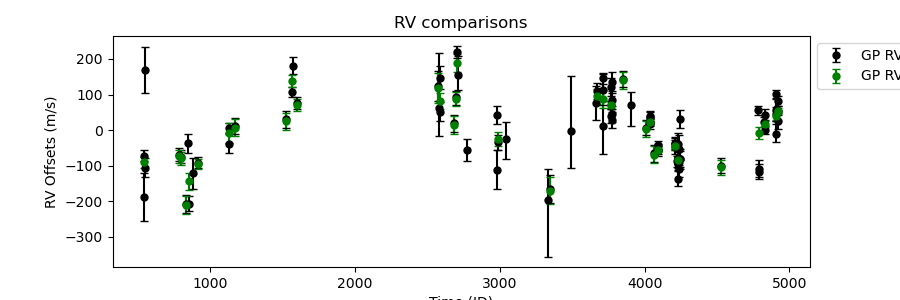

array([ -79.16527913,  -62.22084067,  -68.14581019, -200.11834818,
       -133.19934075,  -84.46200536,    3.18407016,   18.13530566,
         36.62903178,  149.45026408,   81.4577416 ,  130.3438253 ,
         92.03375647,   25.34738122,   98.85880239,  199.39613586,
        -12.72980451, -159.83264846,  105.77395193,   99.17618035,
         81.46051958,  150.73349225,   14.00065367,   34.60604598,
        -58.14533831,  -43.35720729,  -34.3034014 ,  -72.1761834 ,
        -92.89710803,    4.16030238,   29.37519766,   52.01408633,
         64.23441444])

In [53]:
rv_data_20 = pd.read_csv(par_dir + "/data/Posteriors_RV_TESS_20_0_All_ind.csv").ffill().set_index(['Photometry','Sector','RV group'])
rv_data = pd.read_csv(par_dir + "/data/Posteriors_RV.csv").ffill().set_index(['Photometry','Sector','RV group'])
plt.figure(figsize=(9,3))
rv_times_20 = rv_data_20.loc[("TESS_20_0","All")].index.values
rv_times = rv_data.loc[("TESS_20_0","All")].index.values
rv_GP_20 = rv_data_20.loc[("TESS_20_0","All"),("Offset","Inc - Offset","Inc + Offset")].values
rv_GP = rv_data.loc[("TESS_20_0","All"),("Offset","Inc - Offset","Inc + Offset")].values
plt.errorbar(rv_times_20, rv_GP_20[:,0] - np.nanmean(rv_GP_20[:,0]), yerr = rv_GP_20[:,1:3].T, fmt = 'ok', markersize = 5, capsize = 3, label = "GP RV indiv")
plt.errorbar(rv_times, rv_GP[:,0] - np.mean(rv_GP[:,0]), yerr = rv_GP[:,1:3].T, fmt = 'og', markersize = 5, capsize = 3, label = "GP RV groups")
plt.legend(bbox_to_anchor=(1.,1.),loc='upper left')
plt.xlabel("Time (JD)")
plt.ylabel("RV Offsets (m/s)")
plt.title("RV comparisons")
plt.show()


<IPython.core.display.Javascript object>


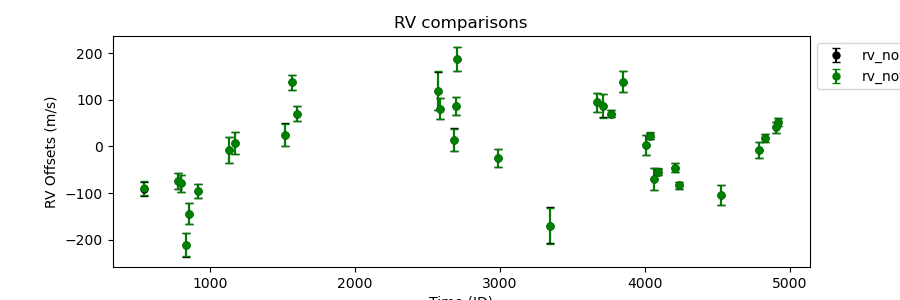

In [78]:
rv_data_norm = pd.read_csv(par_dir + "/data/Posteriors_RV.csv").ffill().set_index(['Photometry','Sector','RV group'])
rv_data_not_norm = pd.read_csv(par_dir + "/data/Posteriors_RV_TESS_19_All.csv").ffill().set_index(['Photometry','Sector','RV group'])

plt.figure(figsize=(9,3))
rv_times_norm = rv_data_norm.loc[("TESS_18_19","Sector3")].index.values
rv_times_not_norm = rv_data_not_norm.loc[("TESS_19","All")].index.values
rv_GP_norm = rv_data_norm.loc[("TESS_18_19","Sector3"),("Offset","Inc - Offset","Inc + Offset")].values
rv_GP_not_norm = rv_data_not_norm.loc[("TESS_19","All"),("Offset","Inc - Offset","Inc + Offset")].values
plt.errorbar(rv_times_norm, rv_GP_norm[:,0] - np.nanmean(rv_GP_norm[:,0]), yerr = rv_GP_norm[:,1:3].T, fmt = 'ok', markersize = 5, capsize = 3, label = "rv_norm_photo")
plt.errorbar(rv_times_not_norm, rv_GP_not_norm[:,0] - np.mean(rv_GP_not_norm[:,0]), yerr = rv_GP_not_norm[:,1:3].T, fmt = 'og', markersize = 5, capsize = 3, label = "rv_not_norm_photo")
plt.legend(bbox_to_anchor=(1.,1.),loc='upper left')
plt.xlabel("Time (JD)")
plt.ylabel("RV Offsets (m/s)")
plt.title("RV comparisons")
plt.show()

In [7]:
### DATA ###
photo_res = pd.read_csv(par_dir + "/data/Posteriors_photometries.csv").ffill().set_index(['Photometry','Sector'])

sectors_names = {"TESS_18_19" : ["All","Sector1","Sector2","Sector3"],
                "TESS_20_0" : ["All","Sector1","Sector2"],
                "TESS_20_1" : ["All","Sector1","Sector2"],
                "TESS_21" : ["All","Sector1","Sector2"]}

rv_time_plot_obs = np.array(["2685.70","2694.56","2707.08","2680-2710","4233.60","4226","4245"])

In [18]:
columns = ["Photometry","Sector","RV group","Likelihood","Log S0","Log Q","Log w0","Offset","Inc - S0","Inc + S0","Inc - Q","Inc + Q","Inc - w0","Inc + w0","Inc - Offset","Inc + Offset"]
rows = sectors_names.keys()
res_test = pd.DataFrame(columns=columns)

for key in sectors_names.keys() :
    for name in sectors_names[key] :
        for i in rv_time_plot_obs :
            df2 = pd.DataFrame([[key,name,i],[]],columns=['Photometry','Sector','RV group'])
            res_test = res_test.append(df2.loc[0])
res_test.set_index(["Photometry","Sector","RV group"],inplace=True)
res_test.sort_index(inplace=True)
res_test

Likelihood Log S0 Log Q Log w0 Offset Inc - S0  \
Photometry Sector  RV group                                                   
TESS_18_19 All     2680-2710        NaN    NaN   NaN    NaN    NaN      NaN   
                   2685.70          NaN    NaN   NaN    NaN    NaN      NaN   
                   2694.56          NaN    NaN   NaN    NaN    NaN      NaN   
                   2707.08          NaN    NaN   NaN    NaN    NaN      NaN   
                   4226             NaN    NaN   NaN    NaN    NaN      NaN   
...                                 ...    ...   ...    ...    ...      ...   
TESS_21    Sector2 2694.56          NaN    NaN   NaN    NaN    NaN      NaN   
                   2707.08          NaN    NaN   NaN    NaN    NaN      NaN   
                   4226             NaN    NaN   NaN    NaN    NaN      NaN   
                   4233.60          NaN    NaN   NaN    NaN    NaN      NaN   
                   4245             NaN    NaN   NaN    NaN    NaN      NaN   

                             Inc + S0 Inc - Q Inc + Q Inc - w0 Inc + w0  \
Photometry Sector  RV group                                               
TESS_18_19 All     2680-2710      NaN     NaN     NaN      NaN      NaN   
                   2685.70        NaN     NaN     NaN      NaN      NaN   
                   2694.56        NaN     NaN     NaN      NaN      NaN   
                   2707.08        NaN     NaN     NaN      NaN      NaN   
                   4226           NaN     NaN     NaN      NaN      NaN   
...                               ...     ...     ...      ...      ...   
TESS_21    Sector2 2694.56        NaN     NaN     NaN      NaN      NaN   
                   2707.08        NaN     NaN     NaN      NaN      NaN   
                   4226           NaN     NaN     NaN      NaN      NaN   
                   4233.60        NaN     NaN     NaN      NaN      NaN   
                   4245           NaN     NaN     NaN      NaN      NaN   

                             Inc - Offset Inc + Offset  
Photometry Sector  RV group                             
TESS_18_19 All     2680-2710          NaN          NaN  
                   2685.70            NaN          NaN  
                   2694.56            NaN          NaN  
                   2707.08            NaN          NaN  
                   4226               NaN          NaN  
...                                   ...          ...  
TESS_21    Sector2 2694.56            NaN          NaN  
                   2707.08            NaN          NaN  
                   4226               NaN          NaN  
                   4233.60            NaN          NaN  
                   4245               NaN          NaN  

[91 rows x 13 columns]

In [21]:
bnds = np.array([2685,2686,2694,2695,2706,2708,2685,2708,4226,4245,4226,4233,4233,4245])

for photometry in sectors_names.keys() :
    
    for name in sectors_names[photometry] :
        posteriors = photo_res.loc[(photometry,name),"Log S0":"Log w0"]
        
        for j in range(np.int(len(bnds)/2)) :
            print(photometry+"/"+name+"/"+rv_time_plot_obs[j]+"\n")
            rv_data = np.loadtxt(par_dir + "/data/rv_betapic_carine.txt",usecols=(0,1,2))
            rv_time = rv_data[:,0]
            rv_flux = rv_data[:,1]
            rv_error = rv_data[:,2]
            index = np.argwhere((rv_time>bnds[j*2])&(rv_time<bnds[(j*2)+1]))
            rv_flux = np.ndarray.flatten(rv_flux[index])*1000
            rv_time = np.sort(np.ndarray.flatten(rv_time[index]))
            rv_error = np.ndarray.flatten(rv_error[index])*1000
            
            
            gp = gp_building(posteriors,rv_time,rv_flux,rv_error)
            sampler,likelihood = run_mcmc(rv_time,rv_flux,gp)
            
            
            flat_samples = sampler.get_chain(discard = 500,thin=15, flat=True)
            labels = ["log(S0)","log(Q)","log(w0)","Offset"]

            rv_posteriors = np.array([])
            rv_posteriors_errors = np.array([])
#             corner.corner(flat_samples, labels=labels, truths=[None,posteriors[1],posteriors[2],None])
#             plt.title("Posteriors_MCMC_RV_%s_%s_%s"%(photometry,name,rv_time_plot_obs[j]))
#             plt.savefig(par_dir + "/plots/%s/%s/Posteriors_MCMC_RV_%s_%s_%s.pdf"%(photometry,name,photometry,name,rv_time_plot_obs[j]),bbox_inches='tight')
#             plt.close()  
        #     plt.show()

#             not_flat_samplers = sampler.get_chain(discard = 500, thin=15,flat=False)
#             fig,ax = plt.subplots(2,2)
#             for i in range(not_flat_samplers.shape[2]) :
#                 for cpt in range(2) :
#                     for cpt_1 in range(2) :
#                         if cpt == 0 :
#                             ax[cpt,cpt_1].plot(not_flat_samplers[:,i,(cpt)+(cpt_1)],linewidth=0.5)
#                             ax[cpt,cpt_1].set_title(labels[(cpt)+(cpt_1)])
#                         if cpt == 1 :
#                             ax[cpt,cpt_1].plot(not_flat_samplers[:,i,(cpt)+(cpt_1+1)],linewidth=0.5)
#                             ax[cpt,cpt_1].set_title(labels[(cpt)+(cpt_1+1)])

#             plt.savefig(par_dir + "/plots/%s/%s/Samplers_MCMC_RV_%s_%s_%s.pdf"%(photometry,name,photometry,name,rv_time_plot_obs[j]),bbox_inches='tight')
#             plt.close() 
        #     plt.show()
        
#             x = np.linspace(np.min(rv_time),np.max(rv_time),15000)
#             pred_mean, pred_var = gp.predict(rv_flux, x, return_var=True)
#             pred_std = np.sqrt(pred_var)

#             color = "#ff7f0e"
#             plt.figure()
#             plt.scatter(rv_time,rv_flux,s=1)
#             plt.plot(x, pred_mean, color=color)
#             plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
#             plt.xlabel("x")
#             plt.ylabel("y")
#             plt.ylim(np.min(rv_flux),np.max(rv_flux))
#             plt.title("Fit_MCMC_RV_%s_%s_%s"%(photometry,name,rv_time_plot_obs[j]))
#             plt.savefig(par_dir + "/plots/%s/%s/Fit_MCMC_RV_%s_%s_%s.pdf"%(photometry,name,photometry,name,rv_time_plot_obs[j]),bbox_inches='tight')
#             plt.close() 
        #     plt.show()

            for i in range(flat_samples.shape[1]):

                mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
                value = np.percentile(flat_samples[:, i], [50])
                q = np.diff(mcmc)
                txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
                txt = txt.format(mcmc[1], q[0], q[1], labels[i])
                display(Math(txt))
                rv_posteriors = np.append(rv_posteriors,value)
                rv_posteriors_errors = np.append(rv_posteriors_errors,q)
                
            res_test.loc[(photometry,name,rv_time_plot_obs[j]),['Likelihood']] = likelihood    
            res_test.loc[(photometry,name,rv_time_plot_obs[j]),"Log S0":"Offset"] = rv_posteriors
            res_test.loc[(photometry,name,rv_time_plot_obs[j]),"Inc - S0" : "Inc + Offset"] = rv_posteriors_errors



  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/All/2685.70

Initial log likelihood: -1108.5971775361438
parameter_dict:
OrderedDict([('kernel:log_S0', -21.05867712761681), ('kernel:log_Q', 2.153635181524829), ('kernel:log_omega0', 5.764505266388031), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [05:30<00:00, 45.33it/s]

Finished
Mean acceptance fraction: 0.585553125
parameter_dict:
OrderedDict([('kernel:log_S0', 2.562328216731451), ('kernel:log_Q', 4.333550571744788), ('kernel:log_omega0', 5.687035377664828), ('mean:value', 0.6359416247229213)])

Final MCMC log likelihood: -258.5989673670679


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_18_19/All/2694.56

Initial log likelihood: -553.06243188476
parameter_dict:
OrderedDict([('kernel:log_S0', -21.05867712761681), ('kernel:log_Q', 2.153635181524829), ('kernel:log_omega0', 5.764505266388031), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:29<00:00, 50.02it/s]


Running production...


100%|██████████| 15000/15000 [05:21<00:00, 46.68it/s]

Finished
Mean acceptance fraction: 0.5795203124999999
parameter_dict:
OrderedDict([('kernel:log_S0', 1.331477112715996), ('kernel:log_Q', 7.064162994735865), ('kernel:log_omega0', 5.763253075472934), ('mean:value', 100.22487000195416)])

Final MCMC log likelihood: -236.2076400361994


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_18_19/All/2707.08

Initial log likelihood: -1184.8418613821893
parameter_dict:
OrderedDict([('kernel:log_S0', -21.05867712761681), ('kernel:log_Q', 2.153635181524829), ('kernel:log_omega0', 5.764505266388031), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:32<00:00, 46.42it/s]


Running production...


100%|██████████| 15000/15000 [05:27<00:00, 45.82it/s]

Finished
Mean acceptance fraction: 0.5874177083333334
parameter_dict:
OrderedDict([('kernel:log_S0', 3.1020568208937953), ('kernel:log_Q', 2.429928723738466), ('kernel:log_omega0', 5.647900526294077), ('mean:value', 187.66238596901792)])

Final MCMC log likelihood: -602.228374105365


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/All/2680-2710

Initial log likelihood: -2846.5014708030926
parameter_dict:
OrderedDict([('kernel:log_S0', -21.05867712761681), ('kernel:log_Q', 2.153635181524829), ('kernel:log_omega0', 5.764505266388031), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/15000 [00:00<05:59, 41.66it/s]

Running production...


100%|██████████| 15000/15000 [05:53<00:00, 42.40it/s]

Finished
Mean acceptance fraction: 0.5899411458333333
parameter_dict:
OrderedDict([('kernel:log_S0', 3.520039931848348), ('kernel:log_Q', 2.1989806633115636), ('kernel:log_omega0', 5.635718408435005), ('mean:value', 121.99806115965734)])

Final MCMC log likelihood: -1112.2179163344456


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/All/4233.60

Initial log likelihood: -15478.642892308244
parameter_dict:
OrderedDict([('kernel:log_S0', -21.05867712761681), ('kernel:log_Q', 2.153635181524829), ('kernel:log_omega0', 5.764505266388031), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [10:24<00:00, 24.03it/s]

Finished
Mean acceptance fraction: 0.5831041666666666
parameter_dict:
OrderedDict([('kernel:log_S0', 2.9759118622472105), ('kernel:log_Q', 2.644510979381821), ('kernel:log_omega0', 5.728838800656445), ('mean:value', -70.26432310482423)])

Final MCMC log likelihood: -4650.464959453863


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/All/4226

Initial log likelihood: -10493.87492261579
parameter_dict:
OrderedDict([('kernel:log_S0', -21.05867712761681), ('kernel:log_Q', 2.153635181524829), ('kernel:log_omega0', 5.764505266388031), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 3/15000 [00:00<08:24, 29.70it/s]

Running production...


100%|██████████| 15000/15000 [08:14<00:00, 30.33it/s]

Finished
Mean acceptance fraction: 0.5840171875
parameter_dict:
OrderedDict([('kernel:log_S0', 2.7850520869909894), ('kernel:log_Q', 3.1900205111089184), ('kernel:log_omega0', 5.723780717402559), ('mean:value', -85.92901894349245)])

Final MCMC log likelihood: -2965.581969942649


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/All/4245

Initial log likelihood: -4984.767969692443
parameter_dict:
OrderedDict([('kernel:log_S0', -21.05867712761681), ('kernel:log_Q', 2.153635181524829), ('kernel:log_omega0', 5.764505266388031), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 4/15000 [00:00<06:59, 35.71it/s]

Running production...


100%|██████████| 15000/15000 [06:41<00:00, 37.32it/s]

Finished
Mean acceptance fraction: 0.5914109375000001
parameter_dict:
OrderedDict([('kernel:log_S0', 3.2112098823533035), ('kernel:log_Q', 2.250266891804895), ('kernel:log_omega0', 5.7368120825765665), ('mean:value', -40.76246176900444)])

Final MCMC log likelihood: -1678.7447495625552


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector1/2685.70

Initial log likelihood: -1108.5971768518828
parameter_dict:
OrderedDict([('kernel:log_S0', -21.74943471810689), ('kernel:log_Q', 2.879152611319988), ('kernel:log_omega0', 5.757251560472405), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 6/15000 [00:00<04:54, 50.84it/s]

Running production...


100%|██████████| 15000/15000 [04:43<00:00, 52.86it/s]

Finished
Mean acceptance fraction: 0.5849947916666667
parameter_dict:
OrderedDict([('kernel:log_S0', 2.638397326603857), ('kernel:log_Q', 4.745202139975156), ('kernel:log_omega0', 5.721005797019875), ('mean:value', 14.896561007431226)])

Final MCMC log likelihood: -257.895409659533


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector1/2694.56

Initial log likelihood: -553.0624315631641
parameter_dict:
OrderedDict([('kernel:log_S0', -21.74943471810689), ('kernel:log_Q', 2.879152611319988), ('kernel:log_omega0', 5.757251560472405), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/15000 [00:00<05:08, 48.54it/s]

Running production...


100%|██████████| 15000/15000 [04:43<00:00, 52.91it/s]

Finished
Mean acceptance fraction: 0.5794869791666666
parameter_dict:
OrderedDict([('kernel:log_S0', 1.5030363070558008), ('kernel:log_Q', 3.5058438255397375), ('kernel:log_omega0', 5.7706128521824045), ('mean:value', 95.8653784651165)])

Final MCMC log likelihood: -234.18844229364973


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector1/2707.08

Initial log likelihood: -1184.8418614075674
parameter_dict:
OrderedDict([('kernel:log_S0', -21.74943471810689), ('kernel:log_Q', 2.879152611319988), ('kernel:log_omega0', 5.757251560472405), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/15000 [00:00<05:26, 45.87it/s]

Running production...


100%|██████████| 15000/15000 [05:15<00:00, 47.61it/s]

Finished
Mean acceptance fraction: 0.5880546874999999
parameter_dict:
OrderedDict([('kernel:log_S0', 2.9126732402547124), ('kernel:log_Q', 2.3484369960568983), ('kernel:log_omega0', 5.691017505086736), ('mean:value', 222.6661673518304)])

Final MCMC log likelihood: -604.162472500136


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_18_19/Sector1/2680-2710

Initial log likelihood: -2846.5014698226128
parameter_dict:
OrderedDict([('kernel:log_S0', -21.74943471810689), ('kernel:log_Q', 2.879152611319988), ('kernel:log_omega0', 5.757251560472405), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/15000 [00:00<05:59, 41.66it/s]

Running production...


100%|██████████| 15000/15000 [05:53<00:00, 42.39it/s]

Finished
Mean acceptance fraction: 0.5898395833333334
parameter_dict:
OrderedDict([('kernel:log_S0', 3.6480551811712747), ('kernel:log_Q', 2.4588566932752696), ('kernel:log_omega0', 5.647942298488276), ('mean:value', 131.88885033738634)])

Final MCMC log likelihood: -1110.8209699100553


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector1/4233.60

Initial log likelihood: -15478.642874947633
parameter_dict:
OrderedDict([('kernel:log_S0', -21.74943471810689), ('kernel:log_Q', 2.879152611319988), ('kernel:log_omega0', 5.757251560472405), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [10:28<00:00, 23.88it/s]

Finished
Mean acceptance fraction: 0.5924197916666667
parameter_dict:
OrderedDict([('kernel:log_S0', 3.088173333315876), ('kernel:log_Q', 2.511169385358906), ('kernel:log_omega0', 5.6835031121539235), ('mean:value', -63.02156916230227)])

Final MCMC log likelihood: -4654.771198463777


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_18_19/Sector1/4226

Initial log likelihood: -10493.87490927446
parameter_dict:
OrderedDict([('kernel:log_S0', -21.74943471810689), ('kernel:log_Q', 2.879152611319988), ('kernel:log_omega0', 5.757251560472405), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 3/15000 [00:00<08:29, 29.41it/s]

Running production...


100%|██████████| 15000/15000 [08:46<00:00, 28.50it/s]

Finished
Mean acceptance fraction: 0.5826098958333334
parameter_dict:
OrderedDict([('kernel:log_S0', 2.0875278825069215), ('kernel:log_Q', 4.544628355269336), ('kernel:log_omega0', 5.7006598872275225), ('mean:value', -90.34498319732062)])

Final MCMC log likelihood: -2973.6515456623088


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector1/4245

Initial log likelihood: -4984.7679656731625
parameter_dict:
OrderedDict([('kernel:log_S0', -21.74943471810689), ('kernel:log_Q', 2.879152611319988), ('kernel:log_omega0', 5.757251560472405), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [06:59<00:00, 35.73it/s]


Finished
Mean acceptance fraction: 0.591209375
parameter_dict:
OrderedDict([('kernel:log_S0', 3.186987028986003), ('kernel:log_Q', 2.2296212271095355), ('kernel:log_omega0', 5.7343848967569775), ('mean:value', -39.140563527693494)])

Final MCMC log likelihood: -1678.7843013067654


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector2/2685.70

Initial log likelihood: -1108.5971777573075
parameter_dict:
OrderedDict([('kernel:log_S0', -20.881503559846912), ('kernel:log_Q', 1.963501515068954), ('kernel:log_omega0', 5.766532749680148), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 2/15000 [00:00<14:37, 17.09it/s]

Running production...


100%|██████████| 15000/15000 [04:59<00:00, 50.12it/s]


Finished
Mean acceptance fraction: 0.5856020833333333
parameter_dict:
OrderedDict([('kernel:log_S0', 3.8569775879121604), ('kernel:log_Q', 5.284891524714574), ('kernel:log_omega0', 5.6700624870847935), ('mean:value', 21.805867080637675)])

Final MCMC log likelihood: -262.91323951090976


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector2/2694.56

Initial log likelihood: -553.0624319938324
parameter_dict:
OrderedDict([('kernel:log_S0', -20.881503559846912), ('kernel:log_Q', 1.963501515068954), ('kernel:log_omega0', 5.766532749680148), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [04:57<00:00, 50.47it/s]


Finished
Mean acceptance fraction: 0.5798557291666666
parameter_dict:
OrderedDict([('kernel:log_S0', 1.6943710889750638), ('kernel:log_Q', 3.1968982408153903), ('kernel:log_omega0', 5.746081429001292), ('mean:value', 111.54387918250794)])

Final MCMC log likelihood: -235.24317243522324


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_18_19/Sector2/2707.08

Initial log likelihood: -1184.8418613764811
parameter_dict:
OrderedDict([('kernel:log_S0', -20.881503559846912), ('kernel:log_Q', 1.963501515068954), ('kernel:log_omega0', 5.766532749680148), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [05:26<00:00, 45.88it/s]

Finished
Mean acceptance fraction: 0.5874390625000001
parameter_dict:
OrderedDict([('kernel:log_S0', 4.484062537121339), ('kernel:log_Q', 1.9140255828993844), ('kernel:log_omega0', 5.65946479112279), ('mean:value', 112.5058324898038)])

Final MCMC log likelihood: -610.6823068069266


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector2/2680-2710

Initial log likelihood: -2846.501471127623
parameter_dict:
OrderedDict([('kernel:log_S0', -20.881503559846912), ('kernel:log_Q', 1.963501515068954), ('kernel:log_omega0', 5.766532749680148), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 2/15000 [00:00<13:52, 18.02it/s]

Running production...


100%|██████████| 15000/15000 [06:05<00:00, 41.09it/s]

Finished
Mean acceptance fraction: 0.5911734375
parameter_dict:
OrderedDict([('kernel:log_S0', 3.6690779357529673), ('kernel:log_Q', 2.5664665403023053), ('kernel:log_omega0', 5.663869321139055), ('mean:value', 126.59413062245065)])

Final MCMC log likelihood: -1110.3326421496702


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector2/4233.60

Initial log likelihood: -15478.64289765507
parameter_dict:
OrderedDict([('kernel:log_S0', -20.881503559846912), ('kernel:log_Q', 1.963501515068954), ('kernel:log_omega0', 5.766532749680148), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [01:01<00:00, 24.29it/s]


Running production...


100%|██████████| 15000/15000 [10:45<00:00, 23.25it/s]

Finished
Mean acceptance fraction: 0.5879916666666667
parameter_dict:
OrderedDict([('kernel:log_S0', 2.8916308553547734), ('kernel:log_Q', 3.1549905250334898), ('kernel:log_omega0', 5.694446748560352), ('mean:value', -70.6550180499394)])

Final MCMC log likelihood: -4652.14156656542


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector2/4226

Initial log likelihood: -10493.874926563387
parameter_dict:
OrderedDict([('kernel:log_S0', -20.881503559846912), ('kernel:log_Q', 1.963501515068954), ('kernel:log_omega0', 5.766532749680148), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [08:26<00:00, 29.64it/s]

Finished
Mean acceptance fraction: 0.5911520833333334
parameter_dict:
OrderedDict([('kernel:log_S0', 2.656038612995841), ('kernel:log_Q', 3.4766554710596584), ('kernel:log_omega0', 5.707647001259632), ('mean:value', -85.89661808150666)])

Final MCMC log likelihood: -2964.92807933489


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector2/4245

Initial log likelihood: -4984.7679710916855
parameter_dict:
OrderedDict([('kernel:log_S0', -20.881503559846912), ('kernel:log_Q', 1.963501515068954), ('kernel:log_omega0', 5.766532749680148), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [06:41<00:00, 37.39it/s]

Finished
Mean acceptance fraction: 0.5915354166666666
parameter_dict:
OrderedDict([('kernel:log_S0', 3.082148837732394), ('kernel:log_Q', 2.1083771529017987), ('kernel:log_omega0', 5.665085487519571), ('mean:value', -0.7569140907463421)])

Final MCMC log likelihood: -1691.513968437352


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector3/2685.70

Initial log likelihood: -1108.5971780937343
parameter_dict:
OrderedDict([('kernel:log_S0', -20.61996223992065), ('kernel:log_Q', 1.6885837125168943), ('kernel:log_omega0', 5.774013539411806), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [04:43<00:00, 52.89it/s]

Finished
Mean acceptance fraction: 0.5856145833333333
parameter_dict:
OrderedDict([('kernel:log_S0', 1.6239361738894424), ('kernel:log_Q', 6.431638553026013), ('kernel:log_omega0', 5.73135874369079), ('mean:value', -21.30786882218667)])

Final MCMC log likelihood: -262.3572635626992


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector3/2694.56

Initial log likelihood: -553.0624321456075
parameter_dict:
OrderedDict([('kernel:log_S0', -20.61996223992065), ('kernel:log_Q', 1.6885837125168943), ('kernel:log_omega0', 5.774013539411806), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 6/15000 [00:00<04:57, 50.42it/s]

Running production...


100%|██████████| 15000/15000 [04:42<00:00, 53.07it/s]

Finished
Mean acceptance fraction: 0.5802729166666666
parameter_dict:
OrderedDict([('kernel:log_S0', 1.5005252161108564), ('kernel:log_Q', 5.373455867748445), ('kernel:log_omega0', 5.758212463546598), ('mean:value', 87.49681309953654)])

Final MCMC log likelihood: -235.05895510243366


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_18_19/Sector3/2707.08

Initial log likelihood: -1184.841861370015
parameter_dict:
OrderedDict([('kernel:log_S0', -20.61996223992065), ('kernel:log_Q', 1.6885837125168943), ('kernel:log_omega0', 5.774013539411806), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/15000 [00:00<05:29, 45.45it/s]

Running production...


100%|██████████| 15000/15000 [05:13<00:00, 47.77it/s]

Finished
Mean acceptance fraction: 0.5873161458333332
parameter_dict:
OrderedDict([('kernel:log_S0', 3.0048879221809415), ('kernel:log_Q', 2.3719604866101403), ('kernel:log_omega0', 5.580910704118358), ('mean:value', 198.98872936758463)])

Final MCMC log likelihood: -602.3792940619552


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector3/2680-2710

Initial log likelihood: -2846.501471609355
parameter_dict:
OrderedDict([('kernel:log_S0', -20.61996223992065), ('kernel:log_Q', 1.6885837125168943), ('kernel:log_omega0', 5.774013539411806), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 4/15000 [00:00<06:14, 40.00it/s]

Running production...


100%|██████████| 15000/15000 [05:51<00:00, 42.63it/s]

Finished
Mean acceptance fraction: 0.5911791666666667
parameter_dict:
OrderedDict([('kernel:log_S0', 3.494490851643192), ('kernel:log_Q', 2.3931514944909047), ('kernel:log_omega0', 5.675012883930266), ('mean:value', 134.29934595743282)])

Final MCMC log likelihood: -1109.8203380424432


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector3/4233.60

Initial log likelihood: -15478.64290584527
parameter_dict:
OrderedDict([('kernel:log_S0', -20.61996223992065), ('kernel:log_Q', 1.6885837125168943), ('kernel:log_omega0', 5.774013539411806), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [10:24<00:00, 24.02it/s]

Finished
Mean acceptance fraction: 0.5822322916666667
parameter_dict:
OrderedDict([('kernel:log_S0', 3.134762975128695), ('kernel:log_Q', 3.0556841569673567), ('kernel:log_omega0', 5.717134604951353), ('mean:value', -73.69428437294177)])

Final MCMC log likelihood: -4652.112541561578


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector3/4226

Initial log likelihood: -10493.874932673914
parameter_dict:
OrderedDict([('kernel:log_S0', -20.61996223992065), ('kernel:log_Q', 1.6885837125168943), ('kernel:log_omega0', 5.774013539411806), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [08:44<00:00, 28.59it/s]

Finished
Mean acceptance fraction: 0.5910359375
parameter_dict:
OrderedDict([('kernel:log_S0', 2.4216479830385502), ('kernel:log_Q', 3.509618354399139), ('kernel:log_omega0', 5.704877839635652), ('mean:value', -89.7311169113704)])

Final MCMC log likelihood: -2966.029107770901


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_18_19/Sector3/4245

Initial log likelihood: -4984.7679731713515
parameter_dict:
OrderedDict([('kernel:log_S0', -20.61996223992065), ('kernel:log_Q', 1.6885837125168943), ('kernel:log_omega0', 5.774013539411806), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:43<00:00, 34.62it/s]


Running production...


100%|██████████| 15000/15000 [07:58<00:00, 31.32it/s]

Finished
Mean acceptance fraction: 0.591496875
parameter_dict:
OrderedDict([('kernel:log_S0', 3.18538545230417), ('kernel:log_Q', 1.9312029751155104), ('kernel:log_omega0', 5.729377438178358), ('mean:value', -51.88953876294891)])

Final MCMC log likelihood: -1679.271569159394


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/All/2685.70

Initial log likelihood: -314.2441381080109
parameter_dict:
OrderedDict([('kernel:log_S0', 8.858849772627723), ('kernel:log_Q', 2.9868736843717585), ('kernel:log_omega0', 5.743940077027047), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:39<00:00, 38.38it/s]


Running production...


100%|██████████| 15000/15000 [05:36<00:00, 44.59it/s]

Finished
Mean acceptance fraction: 0.5848645833333332
parameter_dict:
OrderedDict([('kernel:log_S0', 1.8521545808942763), ('kernel:log_Q', 5.080915684596054), ('kernel:log_omega0', 5.720830052011415), ('mean:value', 25.890830130102266)])

Final MCMC log likelihood: -257.593524005263


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/All/2694.56

Initial log likelihood: -291.45391590414215
parameter_dict:
OrderedDict([('kernel:log_S0', 8.858849772627723), ('kernel:log_Q', 2.9868736843717585), ('kernel:log_omega0', 5.743940077027047), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:31<00:00, 47.12it/s]


Running production...


100%|██████████| 15000/15000 [05:32<00:00, 45.10it/s]

Finished
Mean acceptance fraction: 0.5795635416666667
parameter_dict:
OrderedDict([('kernel:log_S0', 3.150616381668784), ('kernel:log_Q', 4.40896355189674), ('kernel:log_omega0', 5.728775743866171), ('mean:value', 48.388186141628665)])

Final MCMC log likelihood: -238.9000841645357


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/All/2707.08

Initial log likelihood: -706.2556677846679
parameter_dict:
OrderedDict([('kernel:log_S0', 8.858849772627723), ('kernel:log_Q', 2.9868736843717585), ('kernel:log_omega0', 5.743940077027047), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [06:18<00:00, 39.66it/s]

Finished
Mean acceptance fraction: 0.5870666666666666
parameter_dict:
OrderedDict([('kernel:log_S0', 2.6170198371026263), ('kernel:log_Q', 2.4240975773508193), ('kernel:log_omega0', 5.799371366708242), ('mean:value', 196.07397277278807)])

Final MCMC log likelihood: -610.5923886377228


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/All/2680-2710

Initial log likelihood: -1311.9537217968198
parameter_dict:
OrderedDict([('kernel:log_S0', 8.858849772627723), ('kernel:log_Q', 2.9868736843717585), ('kernel:log_omega0', 5.743940077027047), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [06:47<00:00, 36.85it/s]

Finished
Mean acceptance fraction: 0.591221875
parameter_dict:
OrderedDict([('kernel:log_S0', 3.4837720333057045), ('kernel:log_Q', 3.5649122407807736), ('kernel:log_omega0', 5.658544734012685), ('mean:value', 124.94483694226462)])

Final MCMC log likelihood: -1112.033490571344


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_20_0/All/4233.60

Initial log likelihood: -5439.200397955288
parameter_dict:
OrderedDict([('kernel:log_S0', 8.858849772627723), ('kernel:log_Q', 2.9868736843717585), ('kernel:log_omega0', 5.743940077027047), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [01:12<00:00, 20.77it/s]


Running production...


100%|██████████| 15000/15000 [12:29<00:00, 20.02it/s]

Finished
Mean acceptance fraction: 0.5920999999999998
parameter_dict:
OrderedDict([('kernel:log_S0', 3.2210658151573623), ('kernel:log_Q', 2.6204423269905), ('kernel:log_omega0', 5.7214096932242455), ('mean:value', -89.84733803046458)])

Final MCMC log likelihood: -4654.412005049187


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_20_0/All/4226

Initial log likelihood: -3465.145006607074
parameter_dict:
OrderedDict([('kernel:log_S0', 8.858849772627723), ('kernel:log_Q', 2.9868736843717585), ('kernel:log_omega0', 5.743940077027047), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [10:06<00:00, 24.75it/s]

Finished
Mean acceptance fraction: 0.5919697916666666
parameter_dict:
OrderedDict([('kernel:log_S0', 2.564383022476971), ('kernel:log_Q', 2.999883626981989), ('kernel:log_omega0', 5.719120590684102), ('mean:value', -78.93475121283294)])

Final MCMC log likelihood: -2966.010430837175


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_20_0/All/4245

Initial log likelihood: -1974.0553913482145
parameter_dict:
OrderedDict([('kernel:log_S0', 8.858849772627723), ('kernel:log_Q', 2.9868736843717585), ('kernel:log_omega0', 5.743940077027047), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:47<00:00, 31.75it/s]


Running production...


100%|██████████| 15000/15000 [07:14<00:00, 34.56it/s]

Finished
Mean acceptance fraction: 0.5915760416666667
parameter_dict:
OrderedDict([('kernel:log_S0', 3.2300322450797165), ('kernel:log_Q', 0.6465259064852495), ('kernel:log_omega0', 5.784570499476503), ('mean:value', -32.5500603129937)])

Final MCMC log likelihood: -1722.4299475709067


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/Sector1/2685.70

Initial log likelihood: -314.9673856790754
parameter_dict:
OrderedDict([('kernel:log_S0', 8.898938913406607), ('kernel:log_Q', 2.9633317647014703), ('kernel:log_omega0', 5.745130346758717), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 2/15000 [00:00<13:44, 18.18it/s]

Running production...


100%|██████████| 15000/15000 [05:04<00:00, 49.25it/s]

Finished
Mean acceptance fraction: 0.5851390625
parameter_dict:
OrderedDict([('kernel:log_S0', 1.5284265226580809), ('kernel:log_Q', 8.025786107708102), ('kernel:log_omega0', 5.7383647606883175), ('mean:value', 24.895366957098112)])

Final MCMC log likelihood: -261.76599147518806


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/Sector1/2694.56

Initial log likelihood: -292.15638170464825
parameter_dict:
OrderedDict([('kernel:log_S0', 8.898938913406607), ('kernel:log_Q', 2.9633317647014703), ('kernel:log_omega0', 5.745130346758717), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [05:04<00:00, 49.29it/s]

Finished
Mean acceptance fraction: 0.5795
parameter_dict:
OrderedDict([('kernel:log_S0', 1.0252678343810162), ('kernel:log_Q', 6.427643628142264), ('kernel:log_omega0', 5.773141047230571), ('mean:value', 98.38680943412832)])

Final MCMC log likelihood: -235.3563716661693


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/Sector1/2707.08

Initial log likelihood: -707.6648245205988
parameter_dict:
OrderedDict([('kernel:log_S0', 8.898938913406607), ('kernel:log_Q', 2.9633317647014703), ('kernel:log_omega0', 5.745130346758717), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [05:23<00:00, 46.42it/s]


Finished
Mean acceptance fraction: 0.5873614583333333
parameter_dict:
OrderedDict([('kernel:log_S0', 3.2048694690391564), ('kernel:log_Q', 2.3518415358830964), ('kernel:log_omega0', 5.525494870638676), ('mean:value', 207.4678440182138)])

Final MCMC log likelihood: -603.5745231601137


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/Sector1/2680-2710

Initial log likelihood: -1314.7885919043222
parameter_dict:
OrderedDict([('kernel:log_S0', 8.898938913406607), ('kernel:log_Q', 2.9633317647014703), ('kernel:log_omega0', 5.745130346758717), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [05:56<00:00, 42.09it/s]

Finished
Mean acceptance fraction: 0.5904911458333333
parameter_dict:
OrderedDict([('kernel:log_S0', 3.070610353012466), ('kernel:log_Q', 2.831376622385214), ('kernel:log_omega0', 5.765426207773899), ('mean:value', 134.79688327588232)])

Final MCMC log likelihood: -1114.7566748595063


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/Sector1/4233.60

Initial log likelihood: -5450.632814700604
parameter_dict:
OrderedDict([('kernel:log_S0', 8.898938913406607), ('kernel:log_Q', 2.9633317647014703), ('kernel:log_omega0', 5.745130346758717), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [10:44<00:00, 23.28it/s]

Finished
Mean acceptance fraction: 0.5926130208333333
parameter_dict:
OrderedDict([('kernel:log_S0', 3.064877656171196), ('kernel:log_Q', 2.627520357221223), ('kernel:log_omega0', 5.711439310052114), ('mean:value', -88.78356410485858)])

Final MCMC log likelihood: -4652.229148141544


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/Sector1/4226

Initial log likelihood: -3472.2611756643405
parameter_dict:
OrderedDict([('kernel:log_S0', 8.898938913406607), ('kernel:log_Q', 2.9633317647014703), ('kernel:log_omega0', 5.745130346758717), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 3/15000 [00:00<08:49, 28.30it/s]

Running production...


100%|██████████| 15000/15000 [08:24<00:00, 29.74it/s]

Finished
Mean acceptance fraction: 0.5915729166666667
parameter_dict:
OrderedDict([('kernel:log_S0', 2.769484497816705), ('kernel:log_Q', 3.460729656583017), ('kernel:log_omega0', 5.711134945987376), ('mean:value', -92.07910794775651)])

Final MCMC log likelihood: -2965.439025715373


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/Sector1/4245

Initial log likelihood: -1978.3716390362692
parameter_dict:
OrderedDict([('kernel:log_S0', 8.898938913406607), ('kernel:log_Q', 2.9633317647014703), ('kernel:log_omega0', 5.745130346758717), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 4/15000 [00:00<06:41, 37.38it/s]

Running production...


100%|██████████| 15000/15000 [06:45<00:00, 36.96it/s]

Finished
Mean acceptance fraction: 0.5914135416666667
parameter_dict:
OrderedDict([('kernel:log_S0', 3.167167340401677), ('kernel:log_Q', 2.165876270247941), ('kernel:log_omega0', 5.71280785436221), ('mean:value', -44.27517326697549)])

Final MCMC log likelihood: -1678.9014127370738


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/Sector2/2685.70

Initial log likelihood: -313.60419638368876
parameter_dict:
OrderedDict([('kernel:log_S0', 8.823191479481865), ('kernel:log_Q', 3.009962867150601), ('kernel:log_omega0', 5.742817389364436), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 6/15000 [00:00<04:49, 51.72it/s]

Running production...


100%|██████████| 15000/15000 [04:46<00:00, 52.36it/s]

Finished
Mean acceptance fraction: 0.5858770833333333
parameter_dict:
OrderedDict([('kernel:log_S0', 2.1991022634002335), ('kernel:log_Q', 4.712778096450863), ('kernel:log_omega0', 5.719053052933963), ('mean:value', 3.0273130753037076)])

Final MCMC log likelihood: -257.7904340737488


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/Sector2/2694.56

Initial log likelihood: -290.83204026393855
parameter_dict:
OrderedDict([('kernel:log_S0', 8.823191479481865), ('kernel:log_Q', 3.009962867150601), ('kernel:log_omega0', 5.742817389364436), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [04:44<00:00, 52.69it/s]

Finished
Mean acceptance fraction: 0.5799994791666666
parameter_dict:
OrderedDict([('kernel:log_S0', 1.2517919556229828), ('kernel:log_Q', 4.007048170305833), ('kernel:log_omega0', 5.769219009816883), ('mean:value', 101.63717172909338)])

Final MCMC log likelihood: -234.17308598417355


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/Sector2/2707.08

Initial log likelihood: -705.0113574745809
parameter_dict:
OrderedDict([('kernel:log_S0', 8.823191479481865), ('kernel:log_Q', 3.009962867150601), ('kernel:log_omega0', 5.742817389364436), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/15000 [00:00<05:35, 44.64it/s]

Running production...


100%|██████████| 15000/15000 [05:14<00:00, 47.70it/s]

Finished
Mean acceptance fraction: 0.5871776041666668
parameter_dict:
OrderedDict([('kernel:log_S0', 3.3931885890896316), ('kernel:log_Q', 1.6432247273084253), ('kernel:log_omega0', 5.5965233115623665), ('mean:value', 190.931100896843)])

Final MCMC log likelihood: -602.8094478003197


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/Sector2/2680-2710

Initial log likelihood: -1309.447594122208
parameter_dict:
OrderedDict([('kernel:log_S0', 8.823191479481865), ('kernel:log_Q', 3.009962867150601), ('kernel:log_omega0', 5.742817389364436), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [05:53<00:00, 42.42it/s]

Finished
Mean acceptance fraction: 0.5914677083333334
parameter_dict:
OrderedDict([('kernel:log_S0', 3.795095321758411), ('kernel:log_Q', 1.4961760787276062), ('kernel:log_omega0', 5.737077723132686), ('mean:value', 89.67132258178268)])

Final MCMC log likelihood: -1116.6332125553056


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/Sector2/4233.60

Initial log likelihood: -5429.103557744704
parameter_dict:
OrderedDict([('kernel:log_S0', 8.823191479481865), ('kernel:log_Q', 3.009962867150601), ('kernel:log_omega0', 5.742817389364436), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [10:34<00:00, 23.64it/s]

Finished
Mean acceptance fraction: 0.592496875
parameter_dict:
OrderedDict([('kernel:log_S0', 3.070325343302913), ('kernel:log_Q', 2.766451246901456), ('kernel:log_omega0', 5.707409179086737), ('mean:value', -68.40719059172335)])

Final MCMC log likelihood: -4650.12282198379


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/Sector2/4226

Initial log likelihood: -3458.8601510198177
parameter_dict:
OrderedDict([('kernel:log_S0', 8.823191479481865), ('kernel:log_Q', 3.009962867150601), ('kernel:log_omega0', 5.742817389364436), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:49<00:00, 30.15it/s]


Running production...


100%|██████████| 15000/15000 [08:35<00:00, 29.08it/s]

Finished
Mean acceptance fraction: 0.5913458333333335
parameter_dict:
OrderedDict([('kernel:log_S0', 2.664574653656515), ('kernel:log_Q', 3.0257611848755532), ('kernel:log_omega0', 5.712588725917188), ('mean:value', -83.37020697835949)])

Final MCMC log likelihood: -2964.9323969888424


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/Sector2/4245

Initial log likelihood: -1970.2434067248896
parameter_dict:
OrderedDict([('kernel:log_S0', 8.823191479481865), ('kernel:log_Q', 3.009962867150601), ('kernel:log_omega0', 5.742817389364436), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 4/15000 [00:00<06:52, 36.36it/s]

Running production...


100%|██████████| 15000/15000 [07:38<00:00, 32.71it/s]

Finished
Mean acceptance fraction: 0.5914421875
parameter_dict:
OrderedDict([('kernel:log_S0', 3.185594472920201), ('kernel:log_Q', 2.187068074203427), ('kernel:log_omega0', 5.753746956711374), ('mean:value', -57.70466566438556)])

Final MCMC log likelihood: -1679.35574336337


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/All/2685.70

Initial log likelihood: -316.5050547096143
parameter_dict:
OrderedDict([('kernel:log_S0', 9.041638313776112), ('kernel:log_Q', 2.8112440893893185), ('kernel:log_omega0', 5.734320217832478), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [05:30<00:00, 45.44it/s]

Finished
Mean acceptance fraction: 0.5855234375
parameter_dict:
OrderedDict([('kernel:log_S0', 1.9139102219282846), ('kernel:log_Q', 5.515876727585983), ('kernel:log_omega0', 5.738100360863665), ('mean:value', 18.05093286078165)])

Final MCMC log likelihood: -258.87573976161855


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/All/2694.56

Initial log likelihood: -293.6430189998766
parameter_dict:
OrderedDict([('kernel:log_S0', 9.041638313776112), ('kernel:log_Q', 2.8112440893893185), ('kernel:log_omega0', 5.734320217832478), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:31<00:00, 47.56it/s]


Running production...


100%|██████████| 15000/15000 [05:14<00:00, 47.70it/s]

Finished
Mean acceptance fraction: 0.5791052083333335
parameter_dict:
OrderedDict([('kernel:log_S0', 2.462371375159526), ('kernel:log_Q', 3.2803116021822665), ('kernel:log_omega0', 5.82025502090632), ('mean:value', 101.31785171350552)])

Final MCMC log likelihood: -235.71528021474566


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/All/2707.08

Initial log likelihood: -710.6609271909116
parameter_dict:
OrderedDict([('kernel:log_S0', 9.041638313776112), ('kernel:log_Q', 2.8112440893893185), ('kernel:log_omega0', 5.734320217832478), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [05:27<00:00, 45.73it/s]

Finished
Mean acceptance fraction: 0.5872479166666666
parameter_dict:
OrderedDict([('kernel:log_S0', 2.752436011446786), ('kernel:log_Q', 4.967116800794011), ('kernel:log_omega0', 5.602796022947771), ('mean:value', 164.48193060976664)])

Final MCMC log likelihood: -606.2862231782628


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/All/2680-2710

Initial log likelihood: -1320.8090009004022
parameter_dict:
OrderedDict([('kernel:log_S0', 9.041638313776112), ('kernel:log_Q', 2.8112440893893185), ('kernel:log_omega0', 5.734320217832478), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [06:18<00:00, 39.62it/s]

Finished
Mean acceptance fraction: 0.5906598958333333
parameter_dict:
OrderedDict([('kernel:log_S0', 3.846360842878805), ('kernel:log_Q', 2.0407956146757655), ('kernel:log_omega0', 5.671622289608079), ('mean:value', 115.07998332644524)])

Final MCMC log likelihood: -1111.1622589909236


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_20_1/All/4233.60

Initial log likelihood: -5475.373416454811
parameter_dict:
OrderedDict([('kernel:log_S0', 9.041638313776112), ('kernel:log_Q', 2.8112440893893185), ('kernel:log_omega0', 5.734320217832478), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [10:52<00:00, 23.00it/s]


Finished
Mean acceptance fraction: 0.5927197916666667
parameter_dict:
OrderedDict([('kernel:log_S0', 2.891474215615609), ('kernel:log_Q', 2.552278053739999), ('kernel:log_omega0', 5.7240578498836445), ('mean:value', -72.91192042386815)])

Final MCMC log likelihood: -4650.701343462928


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/All/4226

Initial log likelihood: -3487.736414233695
parameter_dict:
OrderedDict([('kernel:log_S0', 9.041638313776112), ('kernel:log_Q', 2.8112440893893185), ('kernel:log_omega0', 5.734320217832478), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [08:44<00:00, 28.58it/s]


Finished
Mean acceptance fraction: 0.591184375
parameter_dict:
OrderedDict([('kernel:log_S0', 2.8082811192711836), ('kernel:log_Q', 3.38382849601058), ('kernel:log_omega0', 5.696660363909236), ('mean:value', -88.6211332750846)])

Final MCMC log likelihood: -2966.0326711588364


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_20_1/All/4245

Initial log likelihood: -1987.6370022211108
parameter_dict:
OrderedDict([('kernel:log_S0', 9.041638313776112), ('kernel:log_Q', 2.8112440893893185), ('kernel:log_omega0', 5.734320217832478), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [06:56<00:00, 35.98it/s]


Finished
Mean acceptance fraction: 0.5914963541666667
parameter_dict:
OrderedDict([('kernel:log_S0', 3.2879076638485496), ('kernel:log_Q', 3.1744381641342176), ('kernel:log_omega0', 5.741786812463718), ('mean:value', -32.24602745642508)])

Final MCMC log likelihood: -1682.4028032998299


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/Sector1/2685.70

Initial log likelihood: -310.89050762473505
parameter_dict:
OrderedDict([('kernel:log_S0', 8.67488359394131), ('kernel:log_Q', 3.177174430992173), ('kernel:log_omega0', 5.734937289519511), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [04:51<00:00, 51.43it/s]

Finished
Mean acceptance fraction: 0.5848239583333333
parameter_dict:
OrderedDict([('kernel:log_S0', 2.46672297877866), ('kernel:log_Q', 7.150840719921279), ('kernel:log_omega0', 5.696084089320917), ('mean:value', -10.12293792401617)])

Final MCMC log likelihood: -260.74591983844147


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/Sector1/2694.56

Initial log likelihood: -288.1918646371712
parameter_dict:
OrderedDict([('kernel:log_S0', 8.67488359394131), ('kernel:log_Q', 3.177174430992173), ('kernel:log_omega0', 5.734937289519511), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [04:40<00:00, 53.44it/s]

Finished
Mean acceptance fraction: 0.5799536458333333
parameter_dict:
OrderedDict([('kernel:log_S0', 2.0593947629265066), ('kernel:log_Q', 1.9596960667171657), ('kernel:log_omega0', 5.76942918950523), ('mean:value', 108.6003543362737)])

Final MCMC log likelihood: -237.4220574429376


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/Sector1/2707.08

Initial log likelihood: -699.7626841438339
parameter_dict:
OrderedDict([('kernel:log_S0', 8.67488359394131), ('kernel:log_Q', 3.177174430992173), ('kernel:log_omega0', 5.734937289519511), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/15000 [00:00<05:14, 47.62it/s]

Running production...


100%|██████████| 15000/15000 [05:11<00:00, 48.15it/s]

Finished
Mean acceptance fraction: 0.5865645833333334
parameter_dict:
OrderedDict([('kernel:log_S0', 2.992947144912569), ('kernel:log_Q', 2.791024720537729), ('kernel:log_omega0', 5.5174898139688695), ('mean:value', 147.32288958205845)])

Final MCMC log likelihood: -607.4021952602749


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/Sector1/2680-2710

Initial log likelihood: -1298.8450564057398
parameter_dict:
OrderedDict([('kernel:log_S0', 8.67488359394131), ('kernel:log_Q', 3.177174430992173), ('kernel:log_omega0', 5.734937289519511), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/15000 [00:00<05:53, 42.37it/s]

Running production...


100%|██████████| 15000/15000 [05:52<00:00, 42.57it/s]

Finished
Mean acceptance fraction: 0.5907729166666666
parameter_dict:
OrderedDict([('kernel:log_S0', 2.835697057418352), ('kernel:log_Q', 2.9194202280497414), ('kernel:log_omega0', 5.712732875534919), ('mean:value', 143.05514184159597)])

Final MCMC log likelihood: -1112.7194545762868


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/Sector1/4233.60

Initial log likelihood: -5386.282136364534
parameter_dict:
OrderedDict([('kernel:log_S0', 8.67488359394131), ('kernel:log_Q', 3.177174430992173), ('kernel:log_omega0', 5.734937289519511), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [10:20<00:00, 24.17it/s]

Finished
Mean acceptance fraction: 0.5838140625
parameter_dict:
OrderedDict([('kernel:log_S0', 2.7449878776471954), ('kernel:log_Q', 2.7641423462086823), ('kernel:log_omega0', 5.7349055441481545), ('mean:value', -68.65476241569625)])

Final MCMC log likelihood: -4652.557126439579


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/Sector1/4226

Initial log likelihood: -3432.1717253777915
parameter_dict:
OrderedDict([('kernel:log_S0', 8.67488359394131), ('kernel:log_Q', 3.177174430992173), ('kernel:log_omega0', 5.734937289519511), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [08:14<00:00, 30.31it/s]

Finished
Mean acceptance fraction: 0.5917739583333333
parameter_dict:
OrderedDict([('kernel:log_S0', 2.8187138324363037), ('kernel:log_Q', 2.6459857655461114), ('kernel:log_omega0', 5.6965756623327835), ('mean:value', -102.66139420630368)])

Final MCMC log likelihood: -2968.9199388102375


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/Sector1/4245

Initial log likelihood: -1954.1104109867347
parameter_dict:
OrderedDict([('kernel:log_S0', 8.67488359394131), ('kernel:log_Q', 3.177174430992173), ('kernel:log_omega0', 5.734937289519511), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 4/15000 [00:00<06:41, 37.38it/s]

Running production...


100%|██████████| 15000/15000 [06:38<00:00, 37.63it/s]

Finished
Mean acceptance fraction: 0.5913291666666667
parameter_dict:
OrderedDict([('kernel:log_S0', 3.3511496648831556), ('kernel:log_Q', 2.811000654219102), ('kernel:log_omega0', 5.70810284607462), ('mean:value', -53.10879968422326)])

Final MCMC log likelihood: -1680.3793424679075


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/Sector2/2685.70

Initial log likelihood: -323.62346736510636
parameter_dict:
OrderedDict([('kernel:log_S0', 9.47489085583265), ('kernel:log_Q', 2.3793155271769333), ('kernel:log_omega0', 5.735750079832671), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 6/15000 [00:00<04:47, 52.17it/s]

Running production...


100%|██████████| 15000/15000 [04:42<00:00, 53.14it/s]

Finished
Mean acceptance fraction: 0.5849489583333333
parameter_dict:
OrderedDict([('kernel:log_S0', 1.611220722173193), ('kernel:log_Q', 2.5476466556653556), ('kernel:log_omega0', 5.743685760590613), ('mean:value', 126.54086169894025)])

Final MCMC log likelihood: -286.1036924372867


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/Sector2/2694.56

Initial log likelihood: -300.5165154055508
parameter_dict:
OrderedDict([('kernel:log_S0', 9.47489085583265), ('kernel:log_Q', 2.3793155271769333), ('kernel:log_omega0', 5.735750079832671), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 6/15000 [00:00<04:42, 53.09it/s]

Running production...


100%|██████████| 15000/15000 [04:39<00:00, 53.63it/s]

Finished
Mean acceptance fraction: 0.5800338541666666
parameter_dict:
OrderedDict([('kernel:log_S0', -0.8846322082463538), ('kernel:log_Q', 7.890671748661265), ('kernel:log_omega0', 5.843918770208073), ('mean:value', 67.86853194960796)])

Final MCMC log likelihood: -256.47561082026766


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/Sector2/2707.08

Initial log likelihood: -724.7842100215431
parameter_dict:
OrderedDict([('kernel:log_S0', 9.47489085583265), ('kernel:log_Q', 2.3793155271769333), ('kernel:log_omega0', 5.735750079832671), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/15000 [00:00<05:08, 48.54it/s]

Running production...


100%|██████████| 15000/15000 [05:10<00:00, 48.33it/s]

Finished
Mean acceptance fraction: 0.587303125
parameter_dict:
OrderedDict([('kernel:log_S0', 3.3919884319196605), ('kernel:log_Q', 1.807551861908014), ('kernel:log_omega0', 5.605864753848075), ('mean:value', 171.2114702479084)])

Final MCMC log likelihood: -602.8885075351624


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/Sector2/2680-2710

Initial log likelihood: -1348.924192792201
parameter_dict:
OrderedDict([('kernel:log_S0', 9.47489085583265), ('kernel:log_Q', 2.3793155271769333), ('kernel:log_omega0', 5.735750079832671), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/15000 [00:00<05:50, 42.73it/s]

Running production...


100%|██████████| 15000/15000 [05:50<00:00, 42.80it/s]

Finished
Mean acceptance fraction: 0.5911953125
parameter_dict:
OrderedDict([('kernel:log_S0', 3.2153673434471757), ('kernel:log_Q', 3.091318530404487), ('kernel:log_omega0', 5.673096257317753), ('mean:value', 132.29517728377314)])

Final MCMC log likelihood: -1110.275932517379


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/Sector2/4233.60

Initial log likelihood: -5591.450560956144
parameter_dict:
OrderedDict([('kernel:log_S0', 9.47489085583265), ('kernel:log_Q', 2.3793155271769333), ('kernel:log_omega0', 5.735750079832671), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [10:21<00:00, 24.13it/s]

Finished
Mean acceptance fraction: 0.5930151041666667
parameter_dict:
OrderedDict([('kernel:log_S0', 3.049879031304613), ('kernel:log_Q', 3.2478426323500806), ('kernel:log_omega0', 5.709535906529639), ('mean:value', -84.52490748717902)])

Final MCMC log likelihood: -4653.228446504572


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/Sector2/4226

Initial log likelihood: -3560.299235185414
parameter_dict:
OrderedDict([('kernel:log_S0', 9.47489085583265), ('kernel:log_Q', 2.3793155271769333), ('kernel:log_omega0', 5.735750079832671), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [08:14<00:00, 30.30it/s]


Finished
Mean acceptance fraction: 0.5916473958333333
parameter_dict:
OrderedDict([('kernel:log_S0', 2.7568362977154424), ('kernel:log_Q', 3.2737655385774036), ('kernel:log_omega0', 5.7542570003840705), ('mean:value', -107.2442901462591)])

Final MCMC log likelihood: -2974.392749895518


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/Sector2/4245

Initial log likelihood: -2031.1513257707315
parameter_dict:
OrderedDict([('kernel:log_S0', 9.47489085583265), ('kernel:log_Q', 2.3793155271769333), ('kernel:log_omega0', 5.735750079832671), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:41<00:00, 35.81it/s]


Running production...


100%|██████████| 15000/15000 [07:25<00:00, 33.65it/s]

Finished
Mean acceptance fraction: 0.5910500000000001
parameter_dict:
OrderedDict([('kernel:log_S0', 3.3182860697079044), ('kernel:log_Q', 2.666633910034781), ('kernel:log_omega0', 5.740820966177749), ('mean:value', -30.127032339127325)])

Final MCMC log likelihood: -1680.7787357569673


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/All/2685.70

Initial log likelihood: -340.89659667395995
parameter_dict:
OrderedDict([('kernel:log_S0', 10.389739592297886), ('kernel:log_Q', 1.3468016602819812), ('kernel:log_omega0', 5.765203050697917), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:30<00:00, 48.62it/s]


Running production...


100%|██████████| 15000/15000 [05:09<00:00, 48.45it/s]

Finished
Mean acceptance fraction: 0.585221875
parameter_dict:
OrderedDict([('kernel:log_S0', 1.3447294529919547), ('kernel:log_Q', 4.216290821430631), ('kernel:log_omega0', 5.7193560682997715), ('mean:value', 52.34213111542865)])

Final MCMC log likelihood: -260.5915180406759


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/All/2694.56

Initial log likelihood: -316.9873255873861
parameter_dict:
OrderedDict([('kernel:log_S0', 10.389739592297886), ('kernel:log_Q', 1.3468016602819812), ('kernel:log_omega0', 5.765203050697917), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 3/15000 [00:00<09:29, 26.31it/s]

Running production...


100%|██████████| 15000/15000 [05:03<00:00, 49.38it/s]

Finished
Mean acceptance fraction: 0.5795614583333334
parameter_dict:
OrderedDict([('kernel:log_S0', 1.1647872950079736), ('kernel:log_Q', 7.625685570414021), ('kernel:log_omega0', 5.727688363403473), ('mean:value', 179.14034721043043)])

Final MCMC log likelihood: -253.43604942063484


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/All/2707.08

Initial log likelihood: -760.8335489150484
parameter_dict:
OrderedDict([('kernel:log_S0', 10.389739592297886), ('kernel:log_Q', 1.3468016602819812), ('kernel:log_omega0', 5.765203050697917), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [05:38<00:00, 44.34it/s]

Finished
Mean acceptance fraction: 0.5870489583333334
parameter_dict:
OrderedDict([('kernel:log_S0', 3.727715338889423), ('kernel:log_Q', 2.257740253419242), ('kernel:log_omega0', 5.488315651497451), ('mean:value', 160.55230815570627)])

Final MCMC log likelihood: -605.0513339040492


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/All/2680-2710

Initial log likelihood: -1418.7174711763942
parameter_dict:
OrderedDict([('kernel:log_S0', 10.389739592297886), ('kernel:log_Q', 1.3468016602819812), ('kernel:log_omega0', 5.765203050697917), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:37<00:00, 39.68it/s]


Running production...


100%|██████████| 15000/15000 [06:22<00:00, 39.18it/s]

Finished
Mean acceptance fraction: 0.5904739583333333
parameter_dict:
OrderedDict([('kernel:log_S0', 3.1234191577598964), ('kernel:log_Q', 2.7808670429787536), ('kernel:log_omega0', 5.676564976349654), ('mean:value', 110.09684722031432)])

Final MCMC log likelihood: -1110.538827973426


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/All/4233.60

Initial log likelihood: -5888.003948395259
parameter_dict:
OrderedDict([('kernel:log_S0', 10.389739592297886), ('kernel:log_Q', 1.3468016602819812), ('kernel:log_omega0', 5.765203050697917), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [11:14<00:00, 22.24it/s]


Finished
Mean acceptance fraction: 0.5925484375
parameter_dict:
OrderedDict([('kernel:log_S0', 3.1066438263962644), ('kernel:log_Q', 2.5462682863482886), ('kernel:log_omega0', 5.71095085970451), ('mean:value', -52.524810290621)])

Final MCMC log likelihood: -4653.397921628326


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/All/4226

Initial log likelihood: -3747.0401777382344
parameter_dict:
OrderedDict([('kernel:log_S0', 10.389739592297886), ('kernel:log_Q', 1.3468016602819812), ('kernel:log_omega0', 5.765203050697917), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [08:53<00:00, 28.14it/s]

Finished
Mean acceptance fraction: 0.591509375
parameter_dict:
OrderedDict([('kernel:log_S0', 2.778669512968957), ('kernel:log_Q', 3.4709802128355474), ('kernel:log_omega0', 5.721316654787381), ('mean:value', -79.60906332094483)])

Final MCMC log likelihood: -2966.175928744752


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/All/4245

Initial log likelihood: -2140.963770657021
parameter_dict:
OrderedDict([('kernel:log_S0', 10.389739592297886), ('kernel:log_Q', 1.3468016602819812), ('kernel:log_omega0', 5.765203050697917), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [07:10<00:00, 34.81it/s]

Finished
Mean acceptance fraction: 0.5883734375
parameter_dict:
OrderedDict([('kernel:log_S0', 2.958385024426851), ('kernel:log_Q', 2.4286312000904564), ('kernel:log_omega0', 5.728438884770247), ('mean:value', -62.20258620824286)])

Final MCMC log likelihood: -1679.7350638338949


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/Sector1/2685.70

Initial log likelihood: -314.727502176515
parameter_dict:
OrderedDict([('kernel:log_S0', 8.925269864029175), ('kernel:log_Q', 2.824141190747258), ('kernel:log_omega0', 5.737511984506668), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [05:08<00:00, 48.67it/s]

Finished
Mean acceptance fraction: 0.585584375
parameter_dict:
OrderedDict([('kernel:log_S0', 2.6476735634027233), ('kernel:log_Q', 4.542849992877414), ('kernel:log_omega0', 5.6948163297342465), ('mean:value', 126.04736786942843)])

Final MCMC log likelihood: -265.3206413944354


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/Sector1/2694.56

Initial log likelihood: -291.91871157696244
parameter_dict:
OrderedDict([('kernel:log_S0', 8.925269864029175), ('kernel:log_Q', 2.824141190747258), ('kernel:log_omega0', 5.737511984506668), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [05:06<00:00, 48.94it/s]

Finished
Mean acceptance fraction: 0.5796015625
parameter_dict:
OrderedDict([('kernel:log_S0', 2.1425035093159255), ('kernel:log_Q', 3.2278531789764378), ('kernel:log_omega0', 5.76065689990647), ('mean:value', 99.57841993648319)])

Final MCMC log likelihood: -234.43423391256601


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/Sector1/2707.08

Initial log likelihood: -707.1868754058873
parameter_dict:
OrderedDict([('kernel:log_S0', 8.925269864029175), ('kernel:log_Q', 2.824141190747258), ('kernel:log_omega0', 5.737511984506668), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:34<00:00, 43.10it/s]


Running production...


100%|██████████| 15000/15000 [05:36<00:00, 44.54it/s]

Finished
Mean acceptance fraction: 0.5872421875
parameter_dict:
OrderedDict([('kernel:log_S0', 2.5563879159094167), ('kernel:log_Q', 3.387898253614017), ('kernel:log_omega0', 5.6417438385094325), ('mean:value', 186.27984989962647)])

Final MCMC log likelihood: -603.6679566481796


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/Sector1/2680-2710

Initial log likelihood: -1313.833089159365
parameter_dict:
OrderedDict([('kernel:log_S0', 8.925269864029175), ('kernel:log_Q', 2.824141190747258), ('kernel:log_omega0', 5.737511984506668), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 4/15000 [00:00<06:37, 37.73it/s]

Running production...


100%|██████████| 15000/15000 [06:20<00:00, 39.43it/s]

Finished
Mean acceptance fraction: 0.5909322916666666
parameter_dict:
OrderedDict([('kernel:log_S0', 3.4218502555504973), ('kernel:log_Q', 2.6362879036340883), ('kernel:log_omega0', 5.699369462922411), ('mean:value', 127.81793760804608)])

Final MCMC log likelihood: -1109.5446321365123


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/Sector1/4233.60

Initial log likelihood: -5447.403946145667
parameter_dict:
OrderedDict([('kernel:log_S0', 8.925269864029175), ('kernel:log_Q', 2.824141190747258), ('kernel:log_omega0', 5.737511984506668), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [11:07<00:00, 22.48it/s]

Finished
Mean acceptance fraction: 0.5927619791666667
parameter_dict:
OrderedDict([('kernel:log_S0', 2.8314632179045836), ('kernel:log_Q', 3.2836602974484608), ('kernel:log_omega0', 5.71229451464881), ('mean:value', -75.767554666517)])

Final MCMC log likelihood: -4650.90197641942


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/Sector1/4226

Initial log likelihood: -3470.3494756283662
parameter_dict:
OrderedDict([('kernel:log_S0', 8.925269864029175), ('kernel:log_Q', 2.824141190747258), ('kernel:log_omega0', 5.737511984506668), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:52<00:00, 28.63it/s]


Running production...


100%|██████████| 15000/15000 [08:54<00:00, 28.06it/s]

Finished
Mean acceptance fraction: 0.5912572916666666
parameter_dict:
OrderedDict([('kernel:log_S0', 2.3076271805704214), ('kernel:log_Q', 3.1557551653606), ('kernel:log_omega0', 5.734058913471153), ('mean:value', -90.21361210881234)])

Final MCMC log likelihood: -2969.630914219722


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/Sector1/4245

Initial log likelihood: -1977.054470517298
parameter_dict:
OrderedDict([('kernel:log_S0', 8.925269864029175), ('kernel:log_Q', 2.824141190747258), ('kernel:log_omega0', 5.737511984506668), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [07:11<00:00, 34.79it/s]

Finished
Mean acceptance fraction: 0.5911203125
parameter_dict:
OrderedDict([('kernel:log_S0', 3.0594234229500143), ('kernel:log_Q', 2.1142840886175343), ('kernel:log_omega0', 5.760459548649801), ('mean:value', -1.268529762644718)])

Final MCMC log likelihood: -1687.1665647785385


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/Sector2/2685.70

Initial log likelihood: -354.59020072648116
parameter_dict:
OrderedDict([('kernel:log_S0', 11.079010145155282), ('kernel:log_Q', 0.6410437483519568), ('kernel:log_omega0', 5.800978065978595), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [05:07<00:00, 48.80it/s]

Finished
Mean acceptance fraction: 0.5851567708333334
parameter_dict:
OrderedDict([('kernel:log_S0', 2.4698850064240347), ('kernel:log_Q', 4.2189276026706795), ('kernel:log_omega0', 5.73375982918224), ('mean:value', 37.99464540573922)])

Final MCMC log likelihood: -258.01840164035576


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/Sector2/2694.56

Initial log likelihood: -329.8722142050805
parameter_dict:
OrderedDict([('kernel:log_S0', 11.079010145155282), ('kernel:log_Q', 0.6410437483519568), ('kernel:log_omega0', 5.800978065978595), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [05:04<00:00, 49.27it/s]

Finished
Mean acceptance fraction: 0.5797104166666667
parameter_dict:
OrderedDict([('kernel:log_S0', 0.4780860600215655), ('kernel:log_Q', 7.735732467669363), ('kernel:log_omega0', 5.776005760644773), ('mean:value', 93.71244730899531)])

Final MCMC log likelihood: -236.69645925292374


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/Sector2/2707.08

Initial log likelihood: -791.4880243268469
parameter_dict:
OrderedDict([('kernel:log_S0', 11.079010145155282), ('kernel:log_Q', 0.6410437483519568), ('kernel:log_omega0', 5.800978065978595), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:33<00:00, 44.71it/s]


Running production...


100%|██████████| 15000/15000 [05:40<00:00, 44.03it/s]

Finished
Mean acceptance fraction: 0.5873229166666667
parameter_dict:
OrderedDict([('kernel:log_S0', 3.4222564407854765), ('kernel:log_Q', 3.6554329139274797), ('kernel:log_omega0', 5.52260326490666), ('mean:value', 195.7759253178207)])

Final MCMC log likelihood: -604.4870855170374


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/Sector2/2680-2710

Initial log likelihood: -1475.9504392584086
parameter_dict:
OrderedDict([('kernel:log_S0', 11.079010145155282), ('kernel:log_Q', 0.6410437483519568), ('kernel:log_omega0', 5.800978065978595), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:37<00:00, 39.81it/s]


Running production...


100%|██████████| 15000/15000 [06:22<00:00, 39.25it/s]


Finished
Mean acceptance fraction: 0.5900463541666666
parameter_dict:
OrderedDict([('kernel:log_S0', 3.41414266496475), ('kernel:log_Q', 2.2711821628109874), ('kernel:log_omega0', 5.699484672929766), ('mean:value', 120.91051074602062)])

Final MCMC log likelihood: -1109.8300274555145


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_21/Sector2/4233.60

Initial log likelihood: -6136.328153198676
parameter_dict:
OrderedDict([('kernel:log_S0', 11.079010145155282), ('kernel:log_Q', 0.6410437483519568), ('kernel:log_omega0', 5.800978065978595), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [01:06<00:00, 22.43it/s]


Running production...


100%|██████████| 15000/15000 [11:08<00:00, 22.44it/s]

Finished
Mean acceptance fraction: 0.5851890625
parameter_dict:
OrderedDict([('kernel:log_S0', 2.991160862399964), ('kernel:log_Q', 2.4398896043114506), ('kernel:log_omega0', 5.711165237714425), ('mean:value', -66.1404140422543)])

Final MCMC log likelihood: -4651.164394871301


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/Sector2/4226

Initial log likelihood: -3904.863599517313
parameter_dict:
OrderedDict([('kernel:log_S0', 11.079010145155282), ('kernel:log_Q', 0.6410437483519568), ('kernel:log_omega0', 5.800978065978595), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [08:52<00:00, 28.19it/s]


Finished
Mean acceptance fraction: 0.5905562499999999
parameter_dict:
OrderedDict([('kernel:log_S0', 2.6884591202227006), ('kernel:log_Q', 3.6135383724008885), ('kernel:log_omega0', 5.710952652282448), ('mean:value', -93.4815842305315)])

Final MCMC log likelihood: -2965.5151851669575


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/Sector2/4245

Initial log likelihood: -2231.464553681362
parameter_dict:
OrderedDict([('kernel:log_S0', 11.079010145155282), ('kernel:log_Q', 0.6410437483519568), ('kernel:log_omega0', 5.800978065978595), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:43<00:00, 34.28it/s]


Running production...


100%|██████████| 15000/15000 [07:08<00:00, 34.97it/s]


Finished
Mean acceptance fraction: 0.5852708333333334
parameter_dict:
OrderedDict([('kernel:log_S0', 2.967591061624469), ('kernel:log_Q', 2.1610284295505657), ('kernel:log_omega0', 5.777584096974078), ('mean:value', -36.74509100494918)])

Final MCMC log likelihood: -1681.901342033137


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [23]:
res_test.to_csv(par_dir + '/data/Posteriors_RV_test.csv')
res_test

Likelihood    Log S0     Log Q    Log w0  \
Photometry Sector  RV group                                               
TESS_18_19 All     2680-2710 -1112.217916  3.410518  2.679916  5.689147   
                   2685.70    -258.598967  2.452915  4.611827  5.711101   
                   2694.56     -236.20764  1.804872  4.138816  5.776706   
                   2707.08    -602.228374  3.359161  2.446828  5.600982   
                   4226       -2965.58197  2.669964  3.294877  5.712585   
...                                   ...       ...       ...       ...   
TESS_21    Sector2 2694.56    -236.696459  1.807934  4.142345  5.776917   
                   2707.08    -604.487086  3.353078   2.46012   5.60067   
                   4226      -2965.515185  2.668787    3.2994  5.712421   
                   4233.60   -4651.164395  2.953296  2.831757  5.714857   
                   4245      -1681.901342  3.229518   2.32213  5.725982   

                                  Offset  Inc - S0  Inc + S0   Inc - Q  \
Photometry Sector  RV group                                              
TESS_18_19 All     2680-2710  123.965115  0.260617  0.278808  0.452923   
                   2685.70     25.228758  0.593748  0.609777  1.102525   
                   2694.56       99.0599  0.883757  0.793419  1.247486   
                   2707.08    198.898087  0.412189  0.468922  0.691921   
                   4226       -87.380951  0.167063  0.173899  0.354179   
...                                  ...       ...       ...       ...   
TESS_21    Sector2 2694.56     99.113364  0.886675  0.792401   1.23486   
                   2707.08    199.199736  0.412726  0.470979  0.696434   
                   4226        -87.37437  0.166061  0.172876  0.349953   
                   4233.60    -72.109065  0.131895  0.137183  0.254054   
                   4245       -48.355008  0.218321  0.236317  0.377821   

                               Inc + Q  Inc - w0  Inc + w0 Inc - Offset  \
Photometry Sector  RV group                                               
TESS_18_19 All     2680-2710  0.537146  0.026142  0.025178    18.289614   
                   2685.70    1.461439  0.020753  0.021025    24.763009   
                   2694.56    1.636637  0.036284  0.030192     20.13735   
                   2707.08    0.874659  0.056903  0.053223    25.696789   
                   4226       0.411471   0.01137  0.010557     8.236241   
...                                ...       ...       ...          ...   
TESS_21    Sector2 2694.56    1.613351  0.036586  0.030145    20.282039   
                   2707.08    0.873601  0.057278  0.053305    25.516986   
                   4226       0.411904  0.011379  0.010478     8.265447   
                   4233.60    0.281693  0.010759  0.010787     7.354639   
                   4245       0.435159  0.024683  0.024326    13.528197   

                             Inc + Offset  
Photometry Sector  RV group                
TESS_18_19 All     2680-2710    18.394364  
                   2685.70      24.364673  
                   2694.56      18.921366  
                   2707.08      26.662144  
                   4226          8.412278  
...                                   ...  
TESS_21    Sector2 2694.56      19.056646  
                   2707.08      26.587048  
                   4226          8.311507  
                   4233.60       7.424331  
                   4245         13.661102  

[91 rows x 13 columns]

<IPython.core.display.Javascript object>


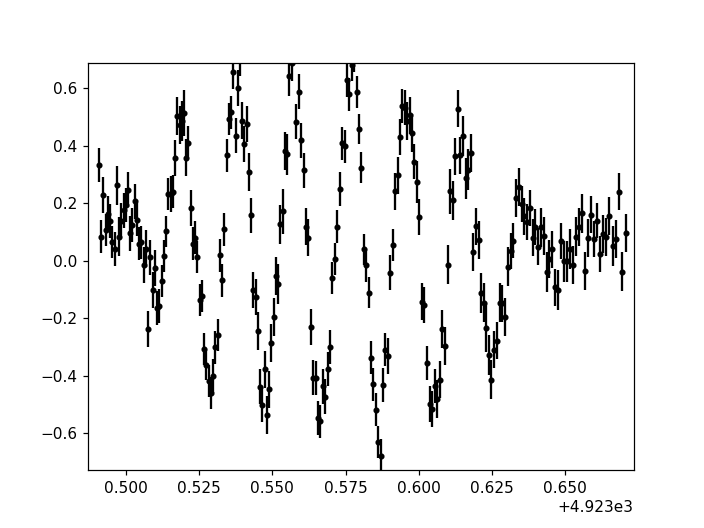

In [31]:
rv_data = np.loadtxt(par_dir + "/data/rv_betapic_carine.txt",usecols=(0,1,2))
rv_time = rv_data[:,0]
rv_flux = rv_data[:,1]
rv_error = rv_data[:,2]
plt.figure()
plt.errorbar(rv_time,rv_flux,yerr=rv_error,fmt='ok',markersize=3,capsize=0)
plt.show()